In [81]:
import juliacall, juliatorch
from juliacall import JuliaError
import torch
from chirho.contrib.experiments.fishery.build_f import (
    build_steady_state_f,
    build_steady_state_fast_f,
    build_temporal_f,
    build_temporal_f_fast,
)
import pyro
import pyro.distributions as dist
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import seaborn as sns

pyro.settings.set(module_local_params=True)

### Preliminary Setup

In [82]:
# Define helpers that take fishing mortality rates, a parameter dict, and initial biomass, and flattens
#  everything into a single tensor that can be passed to a juliatorch JuliaFunction.
def flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    ps = parameters
    return torch.cat(
        [
            initial_biomass,
            torch.stack([
                ps["r1"],
                ps["k1"],
                ps["p12"],
                ps["d1"],
                torch.abs(fishing_mortality_rates[0]),
                ps["r2"],
                ps["e12"],
                ps["p23"],
                ps["d2"],
                torch.abs(fishing_mortality_rates[1]),
                ps["r3"],
                ps["e23"],
                ps["m3"],
                torch.abs(fishing_mortality_rates[2]),
            ]).squeeze()
        ]
    )

def flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times):
    return torch.cat([flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates), times])

In [83]:
# Construct the python function interface to the underlying julia solver
#  of the Zhou and Smith's fishery model (2017)
fishery_steady_state_solver = build_steady_state_f()
fishery_temporal_solver = build_temporal_f()

In [84]:
# Parameters used by Zhao and Smith (2017). We treat these as the true values.
TRUEVALS = OrderedDict(
    k1=1000.0, r1=2.0, r2=1.0, r3=0.25, p12=0.5, p23=0.5, d1=100.0, d2=10.0, e12=0.2, e23=0.2, m3=0.01
)
for k, v in TRUEVALS.items():
    TRUEVALS[k] = torch.tensor(v).double()

# Used to scale up approximately growth proportional fishing rates to absolute fishing rates.
# Note that these are fixed quantities serving only to transform 0-1 fishing rate parameters to absolute rates.
# TODO is this scaling still happening? What is the fishing rate parameter space?
APPROX_GROWTH_RATES = torch.tensor([TRUEVALS["r1"].detach().clone(), TRUEVALS["r2"].detach().clone(), TRUEVALS["r3"].detach().clone()]).double()
NUM_SPECIES = 3

In [85]:
# Approximate equilibrium biomass for the unfished case.
B_UNFISHED = torch.tensor([958.833, 174.356, 33.476]).double()

In [86]:
def fishery_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    flat_ = flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates)
    # print(flat_)  # DEBUG
    biomass_eq = fishery_steady_state_solver(flat_)
    # Sometimes the solver goes infinitesimally negative, which can break logs.
    return torch.relu(biomass_eq) + 1e-10
    
    # # FIXME HACK above is unstable, so just do the fishery temporal solver for a long ways in the future.
    # return torch.relu(fishery_at_times(parameters, initial_biomass, fishing_mortality_rates, torch.tensor([10000.0]))[:, -1])

def fishery_at_times(parameters, initial_biomass, fishing_mortality_rates, times):
    flat_ = flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times)
    # print(flat_)  # DEBUG
    return fishery_temporal_solver(flat_)

### Exploitative Fishing

The narrative begins with exploitative fishing that only considers the maximum sustainable revenue (MSR). For simplicity here, we assume the true parameters are known, and the MSR policy is identified based on those parameters. This policy runs for a number of years, and the biomass is noisily observed at the end of each year.

In [87]:
# Define we dub the maximum sustainable revenue, assuming fixed market prices.
PRICES = torch.tensor([1.0, 20.0, 100.0]).double()

def gross_revenue(biomass, mortality, prices):
    return (biomass * torch.abs(mortality) * prices).sum()

In [88]:
# Use scipy optimize and the true parameter values to find the MSR fishing rates.
def find_msr_fishing_rates(truevals, initial_biomass, prices):
    def objective(mortality_proportions: np.ndarray):
        mortality_rates = torch.tensor(mortality_proportions).double() * APPROX_GROWTH_RATES
        ss = fishery_steady_state(truevals, initial_biomass, mortality_rates)
        msr = gross_revenue(ss, mortality_rates, prices).sum()
        return -msr

    return optimize.minimize(objective, x0=np.array([0.1, 0.1, 0.1]), bounds=[(0.0, 1.0)] * 3).x

In [89]:
msr_rates = torch.tensor(find_msr_fishing_rates(TRUEVALS, B_UNFISHED, PRICES)).double() * APPROX_GROWTH_RATES

In [90]:
# Plot the biomass over time under the MSR policy.
expl_times = torch.arange(0, 5, 0.5)
expl_biomass_at_times = fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, expl_times)

In [91]:
# DEBUG
# fishery_steady_state(TRUEVALS, B_UNFISHED, msr_rates)

In [92]:
# DEBUG
# fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, torch.tensor([0.0, 0.5, 1.0, 10000.0]))

In [93]:
#DEBUG
# torch.abs(fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, torch.tensor([10000.0]))[:, -1])

In [94]:
def plot_biomass_over_time(times, biomass_at_times, logscale=True, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(times, biomass_at_times[0], label="Forage")
    ax.plot(times, biomass_at_times[1], label="Intermediate")
    ax.plot(times, biomass_at_times[2], label="Apex", color="g")
    if logscale:
        ax.set_yscale("log")
    ax.set_ylabel("Biomass")
    ax.set_xlabel("Time")
    ax.legend()
    if show:
        plt.show()
    return fig, ax

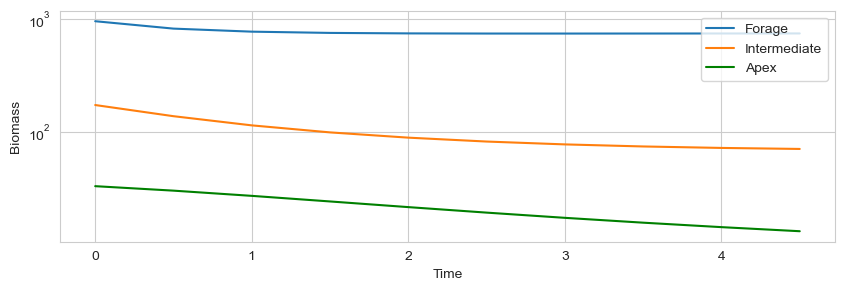

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [95]:
plot_biomass_over_time(expl_times, expl_biomass_at_times)

### Pause on Fishing

The exploitative period ended after concerns developed around the downspin in apex predator numbers. The fishery is paused for a period of time, and the biomass is observed with more frequency.

In [96]:
pause_times = torch.arange(0.1, 1, 0.1)
pause_biomass_at_times = fishery_at_times(TRUEVALS, expl_biomass_at_times[:, -1], torch.zeros_like(msr_rates), pause_times)

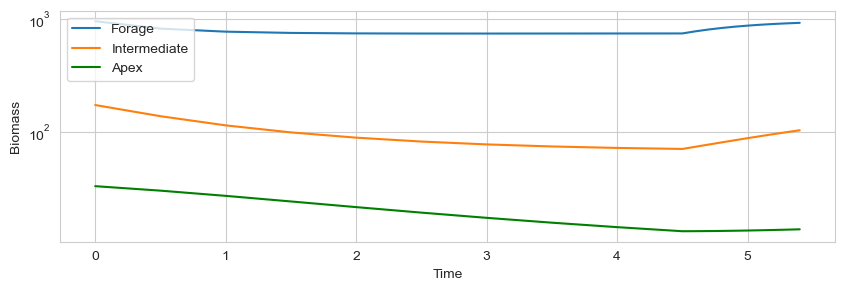

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [97]:
expl_and_pause_times = torch.cat([expl_times, expl_times[-1] + pause_times])
expl_and_pause_biomass_at_times = torch.cat([expl_biomass_at_times, pause_biomass_at_times], dim=1)
plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times)

### Ecologically Aware Fishing

After a few years of exploitative fishing, ecological concerns begin to take more prominence. Our task is to take a high level understanding of fishery parameters (our "prior") and combine that with observed data during the exploitative period. We then seek a new set of fishing rates that also optimize for biodiversity and avoid rare, but catostrophic extinction events.  

#### Prior Definition
TODO port over details from julia file.

In [98]:
# Define prior over parameters of fishery.
# These are set ad-hoc so that the mean is approximately the true value.
# TODO Use now-available helper function lognormal_parameters to compute these directly. 
loc_scale_for_prior = OrderedDict(
    k1=dict(loc=6.94, scale=0.18),
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    p12=dict(loc=-0.70, scale=1.1),
    p23=dict(loc=-0.70, scale=1.1),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    e12=dict(loc=-1.97, scale=0.37),
    e23=dict(loc=-1.97, scale=0.37),
    m3=dict(loc=-4.232, scale=0.6)
)

# Allowing us to slowly scale up the number of stochastic variables in the model.
prior_whitelist = [
    "k1",
    "r1",
    "r2",
    "r3",
    "p12",
    "p23",
    "d1",
    "d2",
    "e12",
    "e23",
    "m3",
    "initial_biomass"
]

def prior():
    od = OrderedDict()
    
    for k, v in loc_scale_for_prior.items():
        if k in prior_whitelist:
            od[k] = pyro.sample(k, dist.LogNormal(**v))
        else:
            # Just do a deterministic site at the true val.
            od[k] = pyro.sample(k, dist.Delta(TRUEVALS[k].detach().clone()))
    
    return od

In [99]:
# Plot the marginals for each parameter, alongisde the approximate lower and upper bounds, and the median.
def plot_marginals(*samples, truevals=None):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    xlims = dict()
    for sample, c in zip(samples, ['purple', 'orange', 'cyan', 'pink', 'black']):
        for i, (name, samples_one_var) in enumerate(sample.items()):
            ax = axs[i // 4, i % 4]
            sns.kdeplot(samples_one_var, ax=ax, color=c)
            ax.axvline(torch.median(samples_one_var), color=c, linestyle="--", linewidth=0.1)
            sq = torch.quantile(samples_one_var, 0.025)
            ax.axvline(sq, color=c, linestyle="--", linewidth=0.3)
            lq = torch.quantile(samples_one_var, 0.975)
            ax.axvline(lq, color=c, linestyle="--", linewidth=0.3)
            ax.set_title(name)
            ax.grid(False)
            if truevals is not None and name != "initial_biomass":  # TODO HACK 2801gdl clean this up 
                ax.axvline(truevals[name], color="k", linestyle="--")
            
            new_xmax = lq*1.5
            xlims[ax] = max(new_xmax, xlims[ax] if ax in xlims else -np.inf)
            ax.set_xlim(0, xlims[ax])
    
    plt.tight_layout()
    return fig, axs

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

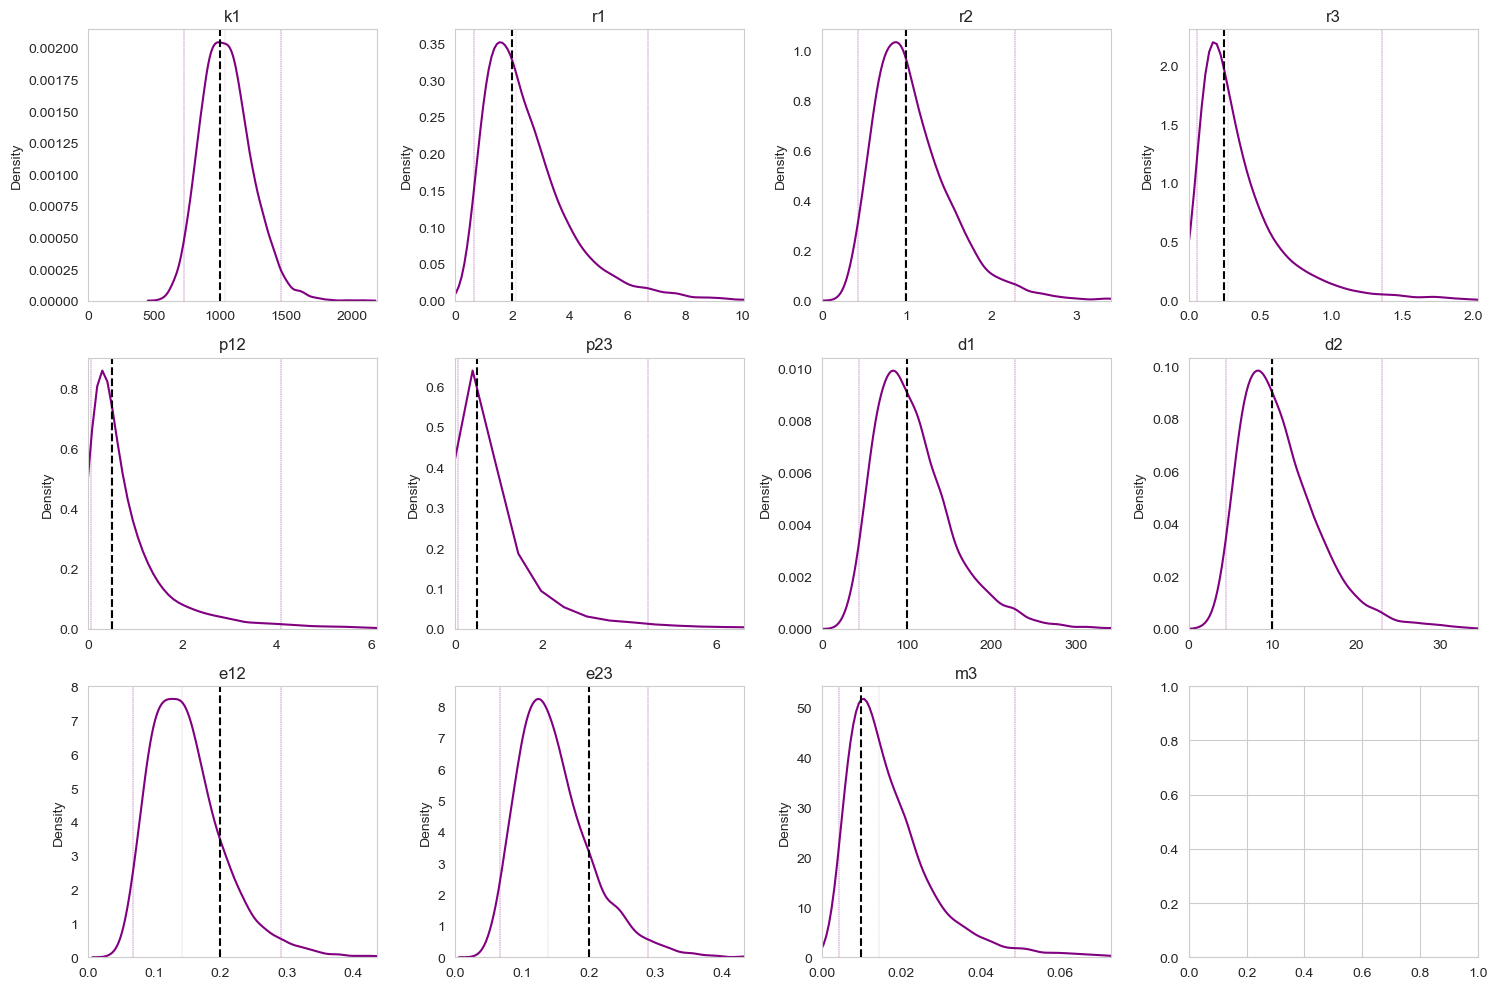

In [100]:
# Sample from the prior
with pyro.plate("samples", 5000):
    plot_marginals(prior(), truevals=TRUEVALS)
plt.show()

#### Observation Noise
Realistically, biomass measurements are noisy. We posit a simple roughly 20% relative error in biomass measurements for each trophic level. In reality, of course, this might differ across strata. 

In [101]:
def lognormal_parameters(mu, sigma):
    sigma_log = torch.log(sigma ** 2. / mu ** 2. + 1.0)
    mu_log = torch.log(mu) - 0.5 * sigma_log
    return mu_log, sigma_log

def observation_model(biomass_at_times, obs_str="obs"):
    # Use lognormals just to fold in the positivity constraints.
    unscaled_noise = 0.5
    sigma = (biomass_at_times ** 0.9) * unscaled_noise
    
    mu_log, sigma_log = lognormal_parameters(biomass_at_times, sigma)
    
    return pyro.sample(obs_str, dist.LogNormal(mu_log, sigma_log).to_event(mu_log.ndim))

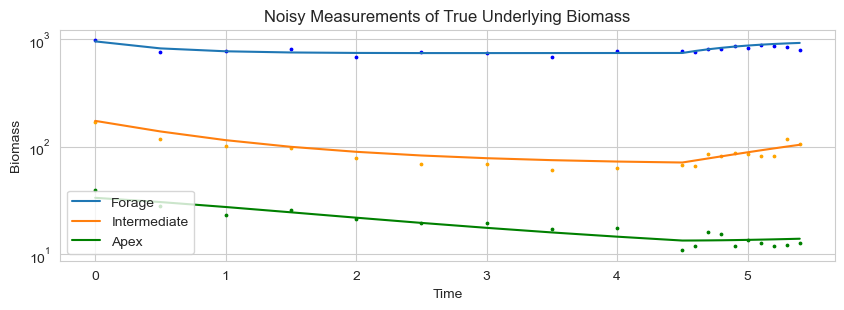

In [102]:
fig, ax = plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times, show=False)

# Plot biomass measurement points.
observed_biomass_at_times = observation_model(expl_and_pause_biomass_at_times)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)
ax.set_title("Noisy Measurements of True Underlying Biomass")
plt.show()

#### Stiching the Model Together
Thus far we've defined a prior, two fishing regimes, and an observation model. We can now stitch these together into a full model. We additionally add prior uncertainty over the initial biomass.

In [103]:
# Add the biomass prior log normal parameters to the dict.
biomass0_mu_log, biomass0_sigma_log = lognormal_parameters(B_UNFISHED, 0.5 * B_UNFISHED)
loc_scale_for_biomass_prior = dict(loc=biomass0_mu_log, scale=biomass0_sigma_log)
def prior_initial_biomass():
    if "initial_biomass" in prior_whitelist:
        return pyro.sample("initial_biomass", dist.LogNormal(**loc_scale_for_biomass_prior).to_event(1))
    else:
        return pyro.sample("initial_biomass", dist.Delta(B_UNFISHED.detach().clone()).to_event(1))

def joint_prior():
    s = prior()
    s["initial_biomass"] = prior_initial_biomass()
    return s

def prior_predictive_fishery_model():
    parameters = prior()
    biomass0 = prior_initial_biomass()
    
    # Exploitative period.
    expl_x = flatten_for_temporal(parameters, biomass0, msr_rates, expl_times)
    expl_mean_y = fishery_temporal_solver(expl_x)
    
    # Pause period.
    pause_x = flatten_for_temporal(parameters, expl_mean_y[:, -1], torch.zeros_like(msr_rates), pause_times)
    pause_mean_y = fishery_temporal_solver(pause_x)
    
    return expl_mean_y, pause_mean_y, parameters, biomass0
    
def full_observed_fishery_model():
    expl_mean_y, pause_mean_y, parameters, biomass0 = prior_predictive_fishery_model()
    
    expl_obs_y = observation_model(expl_mean_y, "expl_obs")
    pause_obs_y = observation_model(pause_mean_y, "pause_obs")
    
    return expl_obs_y, pause_obs_y, expl_mean_y, pause_mean_y, parameters, biomass0

In [104]:
# DEBUG
prior_initial_biomass()


tensor([867.1194, 194.8789,  33.4773], dtype=torch.float64)

#### Visualize Prior Predictive

In [105]:
# Visualize the full model. It should look roughly like what we've plotted above.
obs_expl_biomass_at_times_list, obs_pause_biomass_at_times_list = [], []
mean_expl_biomass_at_times_list, mean_pause_biomass_at_times_list = [], []
for _ in range(1000):
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times, _, _ = full_observed_fishery_model()
    obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times)
    obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times)
    mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times)
    mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times)

obs_expl_biomass_at_times = torch.stack(obs_expl_biomass_at_times_list)
obs_pause_biomass_at_times = torch.stack(obs_pause_biomass_at_times_list)
mean_expl_biomass_at_times = torch.stack(mean_expl_biomass_at_times_list)
mean_pause_biomass_at_times = torch.stack(mean_pause_biomass_at_times_list)

In [106]:
obs_expl_and_pause_biomass_at_times = torch.cat([obs_expl_biomass_at_times, obs_pause_biomass_at_times], dim=-1)
mean_expl_and_pause_biomass_at_times = torch.cat([mean_expl_biomass_at_times, mean_pause_biomass_at_times], dim=-1)

# Get 0.05, 0.5, and 0.95 quantiles for each time point, so we can plot CIs.
obs_expl_and_pause_biomass_at_times_q = torch.quantile(obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
mean_expl_and_pause_biomass_at_times_q = torch.quantile(mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)


In [107]:
def plot_biomass_over_time_with_ci(times, biomass_at_times_q, logscale=True, show=True):
    fig, ax = plot_biomass_over_time(times, biomass_at_times_q[1], logscale, False)
    for i in range(3):
        ax.fill_between(times, biomass_at_times_q[0, i], biomass_at_times_q[2, i], alpha=0.3)
    if show:
        plt.show()
    return fig, ax

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass')

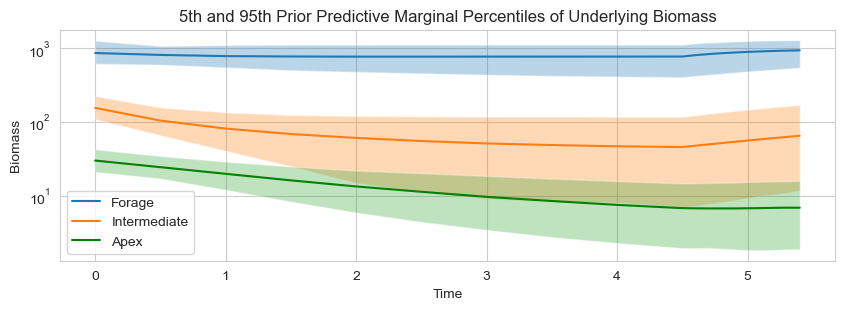

In [108]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, mean_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass")

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements')

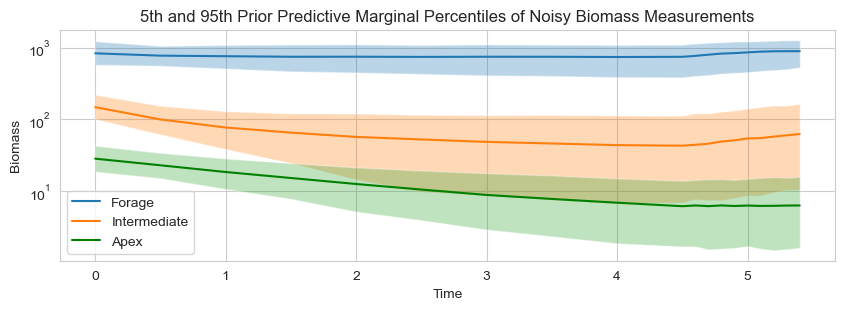

In [109]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, obs_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements")

#### Multi-Objective
After a period of exploitative fishing, policy makers now wish to incorporate ecological objectives. This is formalized as a mult-objective involving a "disturbance index" (Bundy et al. 2005, Zhou and Smith, 2017) that measures the degree of disturbance to the trophic structure relative to the unfished equilibrium state — this acts as a measure of biodiversity. The disturbance index, however, doesn't adequately reflect the  unrecoverable nature of extinction events, so we additionally include a large penalty for cases where the equilibrium state of any trophic level reaches extinction.

In [110]:
def disturbance_index(fished_biomass, unfished_biomass):
    di = 0.0
    for i in range(2):
        di += torch.abs(
            (fished_biomass[i+1] / fished_biomass[i]) - (unfished_biomass[i+1] / unfished_biomass[i])
        )
    return di

def discrete_kl_divergence(p, q):
    return (p * (torch.log(p) - torch.log(q))).sum()
    

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (discrete_kl_divergence(p, m) + discrete_kl_divergence(q, m))

def js_distance(p, q):
    return torch.sqrt(js_divergence(p, q))

def js_disturbance_index(fished_biomass, unfished_biomas):
    # To prevent log(0) issues and instability in proportions when everything goes extinct.
    p = fished_biomass + B_UNFISHED * 1e-2
    q = unfished_biomas + B_UNFISHED * 1e-2
    return js_distance(
        p / p.sum(),
        q / q.sum()
    )
def extinction_event(fished_biomass, unfished_biomass, relaxation=25, threshold=0.15):
    relative_biomass = torch.min(fished_biomass / (unfished_biomass + 1e-2))
    return 1. / (1. + torch.exp(relaxation * (relative_biomass - threshold)))
    

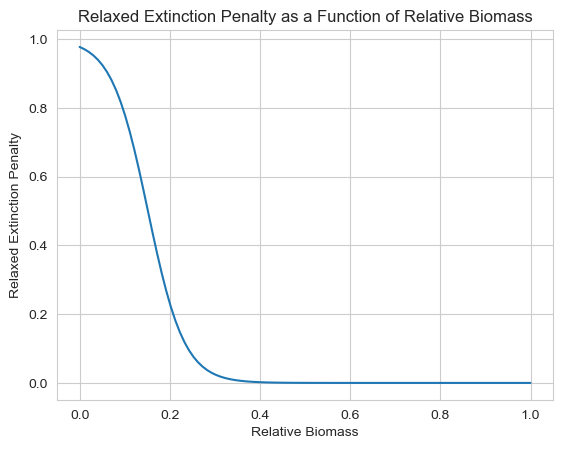

In [111]:
# Plot just the extinction event curve with relative biomass ranging between 0 and 1.
def visualize_extinction_relaxation():
    fished_biomass = torch.linspace(0.0, 1.0, 100)
    unfished_biomass = torch.tensor([1.0])
    plt.plot(fished_biomass, [extinction_event(torch.tensor([f]), unfished_biomass) for f in fished_biomass])
    plt.xlabel("Relative Biomass")
    plt.ylabel("Relaxed Extinction Penalty")
    plt.title("Relaxed Extinction Penalty as a Function of Relative Biomass")
    plt.show()
visualize_extinction_relaxation()

In [112]:
# These different objectives operate on different scales, so we'll need to scale them to be comparable.
 
unfished_ = fishery_steady_state(
    parameters=TRUEVALS,
    initial_biomass=B_UNFISHED,
    fishing_mortality_rates=torch.tensor([0.0, 0.0, 0.0]).double()
)

fisheds = []
mortalities = []

for growth_proportion in range(100):
    mortality = APPROX_GROWTH_RATES * (growth_proportion/100.)
    fished_ = fishery_steady_state(
        parameters=TRUEVALS,
        initial_biomass=B_UNFISHED,
        fishing_mortality_rates=mortality
    )
    fisheds.append(fished_)
    mortalities.append(mortality)

disturbances = torch.stack([disturbance_index(fished, unfished_) for fished in fisheds])
js_disturbances = torch.stack([js_disturbance_index(fished, unfished_) for fished in fisheds])
extinctions = torch.stack([extinction_event(fished, unfished_) for fished in fisheds])
revenues = torch.stack([gross_revenue(
    biomass=fished,
    mortality=mortality,
    prices=PRICES
) for fished, mortality in zip(fisheds, mortalities)])

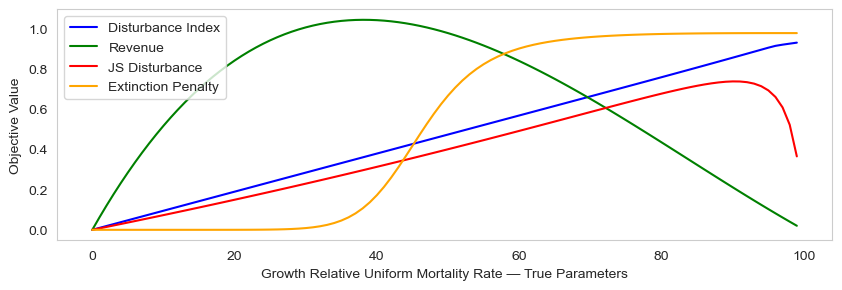

In [113]:
def scale_revenue(revenue):
    return revenue / 1000.0

def scale_disturbance(disturbance):
    return disturbance / 0.4

def scale_js_disturbance(js_disturbance):
    return js_disturbance / .23

def scale_extinction(extinction):
    return extinction

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(scale_disturbance(disturbances), label="Disturbance Index", color="b")
ax.plot(scale_revenue(revenues), label="Revenue", color="g")
ax.plot(scale_js_disturbance(js_disturbances), label="JS Disturbance", color="r")
ax.plot(scale_extinction(extinctions), label="Extinction Penalty", color="orange")

ax.set_xlabel("Growth Relative Uniform Mortality Rate — True Parameters")
ax.set_ylabel("Objective Value")
ax.legend()
ax.grid(False)

### TABDM
TABDM folds inference, prediction, and decision-making together. We'll use it to combine our prior with observed data to prescribe fishing rates that optimize a joint objective. Before, fishery regulators were only interested in maximum sustainable revenue. This led to concerning declines in apex predator numbers. Now, we want to ensure the fishing rates also support biodiversity and avoid rare (low probability), but catastrophic extinction events.

In [114]:
def normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates, return_fuf=False):
    fishing_mortality_rates = torch.abs(fishing_mortality_rates)
    
    fished = fishery_steady_state(
        parameters=parameters,
        initial_biomass=initial_biomass,
        fishing_mortality_rates=fishing_mortality_rates
    )
    
    unfished = fishery_steady_state(
        parameters=parameters,
        initial_biomass=B_UNFISHED,
        fishing_mortality_rates=torch.zeros_like(fishing_mortality_rates)
    )
    
    revenue = scale_revenue(gross_revenue(fished, fishing_mortality_rates, PRICES))
    # disturbance = scale_js_disturbance(js_disturbance_index(fished, unfished))
    # TODO HACK because its unstable and breaks stuff, but we still need it to be gradable for params.
    disturbance = fishing_mortality_rates.sum()
    extinction = scale_extinction(extinction_event(fished, unfished))
    
    if torch.any(fished < 0):
        print("fished < 0", fished.detach().numpy())
        
    if torch.any(unfished < 0):
        print("unfished < 0", unfished.detach().numpy())
    
    if not torch.isfinite(revenue) or revenue < 0:
        print("revenue?", revenue, fished.detach().numpy(), unfished.detach().numpy())
    
    if not torch.isfinite(disturbance) or disturbance < 0:
        print("disturbance?", disturbance, fished.detach().numpy(), unfished.detach().numpy())
        
    if not torch.isfinite(extinction) or extinction < 0:
        print("extinction?", extinction, fished.detach().numpy(), unfished.detach().numpy())
        
    ret = OrderedDict(
            revenue=revenue,
            disturbance=disturbance,
            extinction=extinction
        )
    if return_fuf:
        return ret, fished, unfished
    else:
        return ret

#### Sensitivity Analysis
... This provides intuition about where the objectives are large with respect regions of uncertainty.

In [115]:
n = 300
multiobjective_samples = OrderedDict(
    revenue=torch.zeros(n),
    disturbance=torch.zeros(n),
    extinction=torch.zeros(n)
)
multiobjective_gradient_samples = OrderedDict(
    revenue=torch.zeros(n, NUM_SPECIES),
    disturbance=torch.zeros(n, NUM_SPECIES),
    extinction=torch.zeros(n, NUM_SPECIES)
)
fishery_policy_params_sa = (APPROX_GROWTH_RATES.clone() * 0.3).requires_grad_()
# TODO vectorize.
for i in range(n):
    multiobjective_sample, fished, unfished = normalized_multiobjective(
        prior(),
        pause_biomass_at_times[:, -1],
        fishery_policy_params_sa,
        return_fuf=True
    )
    
    for k, v in multiobjective_sample.items():
        multiobjective_samples[k][i] = v.detach()
    
    # TODO switch to jacobian machinery
    revenue_gradients = torch.autograd.grad(
        outputs=multiobjective_sample["revenue"],
        inputs=fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    disturbance_gradients = torch.autograd.grad(
        multiobjective_sample["disturbance"],
        fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    extinction_gradients = torch.autograd.grad(
        multiobjective_sample["extinction"],
        fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    # TODO also show fd?
    
    # If any gradients are non-finite, identify which one and print out the multi objective
    #  values.
    if not torch.isfinite(revenue_gradients).all():
        print("revenue grad nonfinite", multiobjective_sample)
    if not torch.isfinite(disturbance_gradients).all():
        print("disturbance grad nonfinite", multiobjective_sample)
    if not torch.isfinite(extinction_gradients).all():
        print("extinction grad nonfinite", multiobjective_sample)
    
    if (torch.abs(disturbance_gradients) > 30).any():
        # So the disturbance gradient becomes very large and kind of random when everything goes extinct.
        # The intuition is that tiny changes in fishing pressure in this regime will cause massive changes
        #  to the relative biomass between species (and is probably dominated by solver instability anyway).
        print("-----------------")
        print("disturbance grad large")
        print("fished", fished.detach().numpy())
        print("unfished", unfished.detach().numpy())
        print("disturbance", multiobjective_sample["disturbance"])
        print("gradient", disturbance_gradients.detach().numpy())
        print("-----------------")
    
    for k, v in multiobjective_gradient_samples.items():
        v[i, :] = locals()[f"{k}_gradients"].detach()

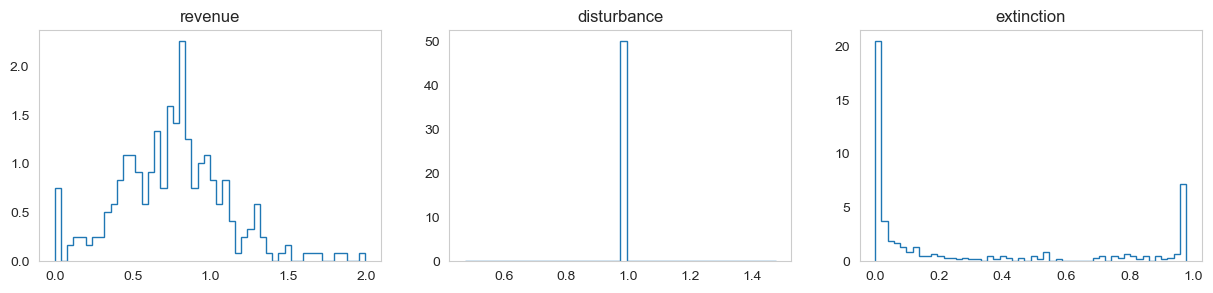

In [116]:
# First, plot the marginals of the objectives.
_, axs = plt.subplots(1, 3, figsize=(15, 3))
for i, (name, samples_one_var) in enumerate(multiobjective_samples.items()):
    ax = axs[i]
    ax.grid(False)
    # sns.kdeplot(samples_one_var, ax=ax)
    ax.hist(samples_one_var, bins=50, histtype="step", density=True)
    ax.set_title(name)

------revenue-------
------Species 0-------
Mean tensor(0.0539)
QL tensor(-0.4017)
QM tensor(0.1675)
QH tensor(0.5053)
Max tensor(1.1287)
Min tensor(-2.2578)
%Finite tensor(1.)
------Species 1-------
Mean tensor(0.4806)
QL tensor(0.0177)
QM tensor(0.5059)
QH tensor(0.9502)
Max tensor(2.7807)
Min tensor(-2.1964)
%Finite tensor(1.)
------Species 2-------
Mean tensor(0.4565)
QL tensor(0.0096)
QM tensor(0.3252)
QH tensor(0.8011)
Max tensor(2.8278)
Min tensor(-0.9347)
%Finite tensor(1.)
------disturbance-------
------Species 0-------
Mean tensor(1.)
QL tensor(1.)
QM tensor(1.)
QH tensor(1.)
Max tensor(1.)
Min tensor(1.)
%Finite tensor(1.)
------Species 1-------
Mean tensor(1.)
QL tensor(1.)
QM tensor(1.)
QH tensor(1.)
Max tensor(1.)
Min tensor(1.)
%Finite tensor(1.)
------Species 2-------
Mean tensor(1.)
QL tensor(1.)
QM tensor(1.)
QH tensor(1.)
Max tensor(1.)
Min tensor(1.)
%Finite tensor(1.)
------extinction-------
------Species 0-------
Mean tensor(0.3828)
QL tensor(0.0006)
QM tensor(0.0

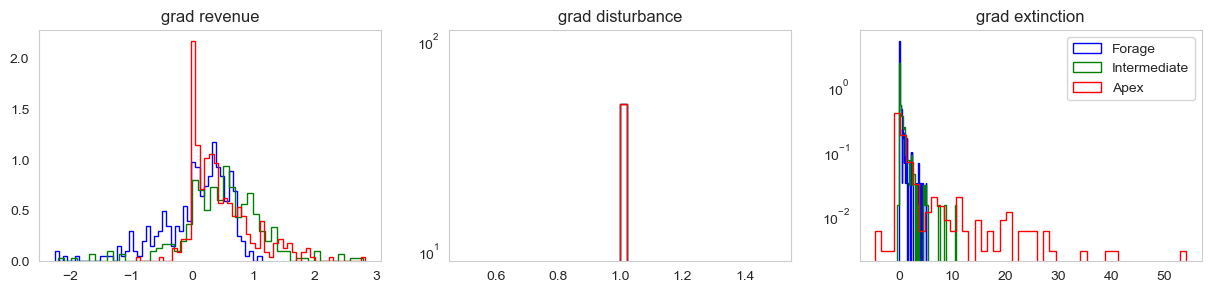

In [117]:
# Now plot the three partials for each component objective in a similar subplot arrangement, but with three lines plotted in each subplot
_, axs = plt.subplots(1, 3, figsize=(15, 3))
colors = ["b", "g", "r"]
labels = ["Forage", "Intermediate", "Apex"]
for i, (name, gradient_samples_one_var) in enumerate(multiobjective_gradient_samples.items()):
    ax = axs[i]
    ax.grid(False)
    print(f"------{name}-------")
    for j in range(NUM_SPECIES):
        # sns.kdeplot(gradient_samples_one_var[:, j], ax=ax, gridsize=1000)
        # hist without filling.
        ax.hist(gradient_samples_one_var[:, j], bins=50, histtype="step", density=True,
                label=labels[j], color=colors[j])
        print(f"------Species {j}-------")
        print("Mean", gradient_samples_one_var[:, j].mean())
        print("QL", gradient_samples_one_var[:, j].quantile(0.2))
        print("QM", gradient_samples_one_var[:, j].quantile(0.5))
        print("QH", gradient_samples_one_var[:, j].quantile(0.8))
        print("Max", gradient_samples_one_var[:, j].max())
        print("Min", gradient_samples_one_var[:, j].min())
        print("%Finite", torch.isfinite(gradient_samples_one_var[:, j]).float().mean())
    ax.set_title(f"grad {name}")

# axs[0].set_xlim(-3, 3)
# axs[1].set_xlim(-1, 2)
# axs[2].set_xlim(-10, 10)
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[2].legend()

#### TABDM Decomposition
In our setting, the optimal proposals for revenue and the disturbance index are slightly skewed, but not particularly heavy-tailed. The extinction penalty, however, shows a small mode in the tails around catostrophic extinctions, and is likely to benefit from target aware approaches. Thus, while we employ the TABI decomposition for revenue and disturbance to debias them, we simply use the posterior approximation as the proposal for all components.

For the extinction event, however, we employ both the full- and single-TABDM approaches with both mixtures of gaussians and expressive normalizing flows. These are further compared to the biased and untargeted monte-carlo approach using a posterior approximation, and PAIS, which does utilize vanilla importance sampling to target the extinction event by incorrectly assuming the posterior approximation is true.

We show weighted, high-sample estimates of the multi-objective at a few checkpoints in the optimization process.

In [118]:
# # Aspects of the multi-objective that aren't tail-heavy.
# def build_rescaled_revenue_and_disturbance_f(fishing_mortality_rates, objective_scaling_dict):
#     def rescaled_revenue_and_disturbance_f(stochastics):
#         initial_biomass = stochastics.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
#         parameters = stochastics
#         multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
#         
#         rescaled_revenue = multiobjective["revenue"] * objective_scaling_dict["revenue"]
#         rescaled_disturbance = multiobjective["disturbance"] * objective_scaling_dict["disturbance"]
#         
#         return rescaled_revenue - rescaled_disturbance
#     
#     return rescaled_revenue_and_disturbance_f
# 
# # Aspect of the multi-objective that is tail-heavy.
# def build_rescaled_extinction_f(fishing_mortality_rates, objective_scaling_dict):
#     def rescaled_extinction_f(stochastics):
#         initial_biomass = stochastics.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
#         parameters = stochastics
#         multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
#         
#         rescaled_extinction = multiobjective["extinction"] * objective_scaling_dict["extinction"]
#         
#         return -rescaled_extinction
#     return rescaled_extinction_f

from copy import copy
from typing import Dict, Optional, Callable

ObjFnType = Callable[[OrderedDict[str, torch.Tensor], torch.Tensor], torch.Tensor]
StochType = OrderedDict[str, torch.Tensor]

# Just the full multiobjective.
def build_full_rescaled_multiobjective_f(
        objective_scaling_dict: Dict,
        return_vec=False
) -> ObjFnType:
    def full_rescaled_multiobjective_f(
            stochastics: StochType,
            fishing_mortality_rates: torch.Tensor
    ):  
        stochastics = copy(stochastics)
        initial_biomass = stochastics.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
        parameters = stochastics
        multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
        
        rescaled_revenue = multiobjective["revenue"] * objective_scaling_dict["revenue"]
        rescaled_disturbance = multiobjective["disturbance"] * objective_scaling_dict["disturbance"]
        rescaled_extinction = multiobjective["extinction"] * objective_scaling_dict["extinction"]
        
        if not return_vec:
            return rescaled_revenue - rescaled_disturbance - rescaled_extinction
        else:
            return torch.cat([rescaled_revenue[None], -rescaled_disturbance[None], -rescaled_extinction[None]])
        
    return full_rescaled_multiobjective_f


def build_jac(obj_fn: ObjFnType, create_graph=True):
    def compute_jac(stochastics: StochType, fishing_mortality_rates: torch.Tensor):
        
        def policy_param_closure(fmr):
            return obj_fn(stochastics, fmr)
        
        # Must create_graph=True so that the ELBO can be pushed back through this via a log factor in pseudens.
        jac = torch.autograd.functional.jacobian(
            policy_param_closure,
            fishing_mortality_rates,
            create_graph=create_graph,
            strict=True
        )
        
        return jac
    
    return compute_jac


def build_fd_jac_ij(
        obj_fn: ObjFnType,
        output_idx: int,
        input_idx: int,
        fishing_mortality_rates_outer: Optional[torch.Tensor] = None,
        eps=4e-2
):
    """
    Build a function that computes the finite difference approximation of a single cell of the jacobian matrix.
    This will be used instead of the standard jacobian, and then differentiated with respect to the stochastics
     for fitting a proposal distribution to a pseudo density with a factor involving this approximate gradient.
    
    See FIXME tag 4wc0qtdk:
    Differentiating through the analytic jacobian a second time is unstable and/or wrong, so doing this instead.
    
    Note that obj_fn must have been built to return a vector.
    """
    def compute_fd_jac_ij(stochastics: StochType, fishing_mortality_rates: Optional[torch.Tensor] = None):
        
        if fishing_mortality_rates is None:
            fishing_mortality_rates = fishing_mortality_rates_outer
        
        # This is the cell of the jacobian matrix we want to approximate.
        # We'll vary the fishing mortality rate parameter a tiny amount in each direction,
        #  get the difference and approximate the local gradient.
        fmr = fishing_mortality_rates.detach().clone()
        fmr[input_idx] += eps
        # Technically we're approximating the entire jacobian column here.
        # TODO if we end up using this for multiple outputs we can take advantage of that.
        #  As of 2024.05.27 though we are only using this for a single output.
        obj_plus = obj_fn(stochastics, fmr)[output_idx] 
        
        fmr = fishing_mortality_rates.detach().clone()
        fmr[input_idx] -= eps
        obj_minus = obj_fn(stochastics, fmr)[output_idx]
        
        return (obj_plus - obj_minus) / (2. * eps)
    
    return compute_fd_jac_ij

In [119]:
# TESTING
from itertools import product

stochs = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}

fpp = msr_rates.detach().clone().requires_grad_() * 0.8

frmo = build_full_rescaled_multiobjective_f(
    dict(revenue=1.0, disturbance=1.0, extinction=10.0),
    return_vec=False
)

frmo_jac = build_jac(frmo)
frmo_jac_val = frmo_jac(stochs, fpp)
# print(frmo_jac(stochs, fpp))

# print()

frmo_vec = build_full_rescaled_multiobjective_f(
    dict(revenue=1.0, disturbance=1.0, extinction=10.0),
    return_vec=True
)

frmo_jac_vec = build_jac(frmo_vec)
full_jac = frmo_jac_vec(stochs, fpp)
# print(full_jac)
# print(full_jac.sum(axis=0))  # sum over rows (outputs) to get grads for columns (inputs)
full_jac_sum_val = full_jac.sum(axis=0)
assert torch.allclose(full_jac_sum_val, frmo_jac_val)

# Grad check fishing params without stochs.
torch.autograd.gradcheck(lambda x: frmo(stochs, x), (fpp,))
print("Passed fpp gradcheck.")

# Do a grad check of stochastics, not fishing policy params, through the jacobian function.
def gradcheck_fn_wrt_stochs(fn):
    for k, v in stochs.items():
        v.requires_grad_()
        _ = (lambda x: fn(stochs | {k: x}, fpp))(v)  # runtime check of closure.
        torch.autograd.gradcheck(lambda x: fn(stochs | {k: x}, fpp), (v,))


# Dummy test.
def dummy_fn(s, p):
    ret = 0.0
    for k, v in s.items():
        ret += v.sum() ** 2.
    return ret + p.sum() ** 2.

dummy_fn_jac = build_jac(dummy_fn)
gradcheck_fn_wrt_stochs(dummy_fn)
gradcheck_fn_wrt_stochs(dummy_fn_jac)
print("Passed dummy_fn stochs gradcheck.")

gradcheck_fn_wrt_stochs(frmo)
print("Passed frmo stochs gradcheck.")
gradcheck_fn_wrt_stochs(frmo_vec)
print("Passed frmo_vec stochs gradcheck.")

# FIXME tag 4wc0qtdk diffing through these analytic jacobians fails. Is wrong or unstable.
# gradcheck_fn_wrt_stochs(frmo_jac)
# print("Passed frmo_jac stochs gradcheck.")
# gradcheck_fn_wrt_stochs(frmo_jac_vec)

# Gradcheck the FD jacobian.
for i, j in product(range(3), range(3)):
    fd_jac_ij = build_fd_jac_ij(frmo_vec, i, j)
    gradcheck_fn_wrt_stochs(fd_jac_ij)
    print("Passed FD gradcheck for", i, j)

Passed fpp gradcheck.
Passed dummy_fn stochs gradcheck.
Passed frmo stochs gradcheck.
Passed frmo_vec stochs gradcheck.
Passed FD gradcheck for 0 0
Passed FD gradcheck for 0 1
Passed FD gradcheck for 0 2
Passed FD gradcheck for 1 0
Passed FD gradcheck for 1 1
Passed FD gradcheck for 1 2
Passed FD gradcheck for 2 0
Passed FD gradcheck for 2 1
Passed FD gradcheck for 2 2


In [120]:
OBJECTIVE_SCALING_DICT = dict(
    revenue=1.0,
    disturbance=0.0,  # ignoring this for simplicity.
    extinction=10.0,
)

In [121]:
# Here we provide a slightly different analysis aimed at understanding the rarity of non-zero gradients across the relevant space of policy parameters.
def nonzero_extinction_gradient_proportion_against_fishing_rates(nsamples=1000, eps=1e-3, use_fd=False, **kwargs):
    # We're only going to look at variations in the intermediate and apex rates, as the forage rates
    #  affect all higher trophic levels proportionally.
    forage_rate = torch.tensor(0.3) * APPROX_GROWTH_RATES[0]
    
    # And a uniform range for the predators.
    non_forage_rate_low = torch.zeros(2)
    non_forage_rate_high = APPROX_GROWTH_RATES[1:].detach().clone() * 1.5
    
    # The multiobjective with return vector.
    frmo_vec = build_full_rescaled_multiobjective_f(
        OBJECTIVE_SCALING_DICT,
        return_vec=True
    )
    
    if use_fd:
        frmo_fd_jac_in0 = build_fd_jac_ij(frmo_vec, output_idx=slice(0, 3), input_idx=0)
        frmo_fd_jac_in1 = build_fd_jac_ij(frmo_vec, output_idx=slice(0, 3), input_idx=1)
        frmo_fd_jac_in2 = build_fd_jac_ij(frmo_vec, output_idx=slice(0, 3), input_idx=2)
        def frmo_jac_vec(s_, fr_):
            return torch.stack([
                frmo_fd_jac_in0(s_, fr_),
                frmo_fd_jac_in1(s_, fr_),
                frmo_fd_jac_in2(s_, fr_)
            ]).transpose_(0, 1)
    else:
        # The jacobian of the multiobjective.
        frmo_jac_vec = build_jac(frmo_vec)
    
    all_jacs = []
    all_nfrs = []
    
    for n in range(nsamples):
        print(f"Sample {n:0{len(str(nsamples))}}/{nsamples}", end="\r")
        
        # Sample the policy parameters.
        non_forage_rate = dist.Uniform(non_forage_rate_low, non_forage_rate_high).sample()
        all_nfrs.append(non_forage_rate)
        fishing_rates = torch.cat([forage_rate[None], non_forage_rate])
        
        # Sample system latent parameters.
        s = joint_prior()
        
        # Compute the jacobian.
        try:
            # if n % 3 == 0:
            #     raise JuliaError("testing only.")
            
            all_jacs.append(frmo_jac_vec(s, fishing_rates))
        except JuliaError as e:
            print("Failed jac computation:", str(e)[:40])
            all_jacs.append(torch.zeros(3, 3) * torch.nan)
        
    all_jacs = torch.stack(all_jacs)  # .shape == (nsamples, 3, 3)
    all_nfrs_np = torch.stack(all_nfrs).detach().numpy()  # .shape == (nsamples, 2)
    
    # We now want a 3x3 set of plots.
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    
    for row_idx, col_idx in product(range(3), range(3)):
        ax = axs[row_idx, col_idx]
        
        # Plot a diagonal line.
        ax.plot([0, 1.5], [0, 1.5], color="black", linestyle="--", linewidth=0.2)
        # But keep xlim and ylim the same.
        ax.set_xlim(0, non_forage_rate_high[0].item())
        ax.set_ylim(0, non_forage_rate_high[1].item())
        
        # Get the gradient values for the current cell.
        grad_vals = all_jacs[:, row_idx, col_idx]
        nz_grads = torch.zeros_like(grad_vals).bool()
        nz_grads[torch.abs(grad_vals) > eps] = True
        nz_grads_np = nz_grads.detach().numpy()
        nan_grads_np = torch.isnan(grad_vals).detach().numpy()
        
        # Index to get the positions.
        nz_grad_nfrs = all_nfrs_np[nz_grads_np & ~nan_grads_np]
        z_grad_nfrs = all_nfrs_np[~nz_grads_np & ~nan_grads_np]
        nan_grad_nfrs = all_nfrs_np[nan_grads_np]
        
        # Scatter plot the non-zero points in pink and zero points in cyan. Failed points go in black with cross.
        ax.scatter(z_grad_nfrs[:, 0], z_grad_nfrs[:, 1], color="cyan", **kwargs)
        ax.scatter(nz_grad_nfrs[:, 0], nz_grad_nfrs[:, 1], color="pink", **kwargs)
        ax.scatter(nan_grad_nfrs[:, 0], nan_grad_nfrs[:, 1], color="black", marker="x", alpha=1.0, s=10., linewidth=0.5)
        
        # If the last row, label the x axis as intermediate fishing rate.
        if row_idx == 2:
            ax.set_xlabel("Intermediate Fishing Rate")
        
        # If the first column, label the y axis as apex fishing rate.
        if col_idx == 0:
            ax.set_ylabel("Apex Fishing Rate")
    
    plt.show()

In [122]:
# Commented out b/c long runtime.
# nonzero_extinction_gradient_proportion_against_fishing_rates(nsamples=5000, alpha=0.3, s=7., use_fd=True)

In [123]:
# Commented out b/c long runtime.
# nonzero_extinction_gradient_proportion_against_fishing_rates(nsamples=5000, alpha=0.3, s=7., use_fd=False)

In [124]:
# # DEBUG WIP checking if we can pass a slice as the output_idx of the build_fd_jac_ij function.
# fd_jac_all_outs_fn = build_fd_jac_ij(frmo_vec, output_idx=slice(0, 3), input_idx=0)  # douts / dforage
# fd_jac_all_outs = fd_jac_all_outs_fn(stochs, fpp)
# print(fd_jac_all_outs)

In [125]:
# # TESTING
# # Compare the revenue component of the analytic jacobian to the fd jacobian.
# out_idx = 2
# for input_idx in range(3):
#     fd_jac_rev = build_fd_jac_ij(frmo_vec, output_idx=out_idx, input_idx=input_idx, fishing_mortality_rates_outer=fpp, eps=1e-5)
#     fd_jac_rev_val = fd_jac_rev(stochs, fpp)
#     ana_jac_rev_val = frmo_jac_vec(stochs, fpp)[out_idx, input_idx]
#     
#     print("Revenue component of analytic jacobian", ana_jac_rev_val)
#     print("Revenue component of FD jacobian", fd_jac_rev_val)
#     print()

In [214]:
from contextlib import contextmanager

@contextmanager
def solver_error_suppression(): 
    attempt_str = f"Reattempting may result in bias."
    try:
        yield
        return
    except JuliaError as e:
        print(f"Failed with JuliaError: {str(e)[:40]}")
        print(attempt_str)
    except RuntimeError as e:
        if "is non-finite" in str(e):
            print(f"Failed finite check: {str(e)[:40]}")
            print(attempt_str)
        else:
            print("DEBUG got thing but didn't catch")
            raise
    
    raise RuntimeError("Failed all attempts.")

In [200]:
from contextlib import nullcontext

def build_estimate_log_normalizing_constant(pseudo_density, proposal, no_grad=True):
    """
    Use the fact that the elbo loss encodes an importance sampling estimate of a normalizing constant for any pseudo density.
    :param pseudo_density: Typically, the utility function times the unnormalized posterior.
    :param proposal: Some proposal distribution, typically approximating pseudo_density.
    :param no_grad: Whether to support differentiation through the estimate. Not generally used if already estimating gradients.
    :return: A function that returns estimates of the normalizing constant.
    """
    elbo = pyro.infer.Trace_ELBO()(pseudo_density, proposal)
    
    def estimate_log_normalizing_constant():
        handler = torch.no_grad if no_grad else nullcontext
        with handler():
            return -elbo()
    
    return estimate_log_normalizing_constant

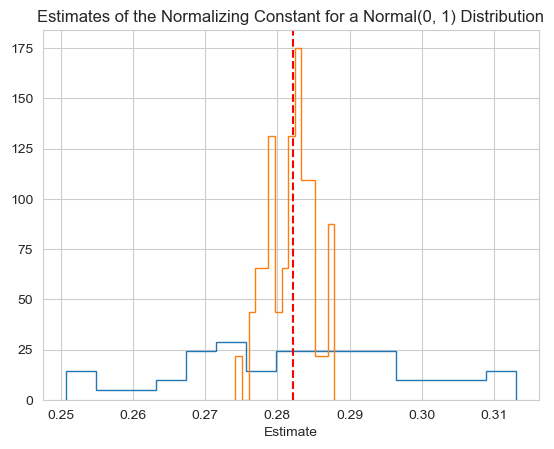

In [201]:
# A simple demonstration of the above, estimating squared density.
def simple_elbo_is_demo():
    def model():
        return pyro.sample("x", dist.Normal(0., 1.))
    
    # The thing we're going to estimate the normalizing constant for. I.e. the expected density of a distribution wrt itself.
    def pseudo_density():
        x = model()
        pyro.factor("unnorm_unit_norm", dist.Normal(0., 1.).log_prob(x))
    
    def meh_proposal():
        pyro.sample("x", dist.Normal(.1, 1.))
    
    # As the proposal converges to the normalized pseudo_density, estimates become exact.
    def good_proposal():
        pyro.sample("x", dist.Normal(-.05, 0.7))
    
    meh_estimate_log_normalizing_constant = build_estimate_log_normalizing_constant(pseudo_density, meh_proposal)
    good_estimate_log_normalizing_constant = build_estimate_log_normalizing_constant(pseudo_density, good_proposal)
    
    # Loop through and use each to estimate the normalizing constant (expected density).
    meh_estimates = []
    good_estimates = []
    for _ in range(50):
        meh_inner_estimates = []
        good_inner_estimates = []
        for _ in range(50):
            meh_inner_estimates.append(meh_estimate_log_normalizing_constant().exp())
            good_inner_estimates.append(good_estimate_log_normalizing_constant().exp())
        meh_estimates.append(torch.tensor(meh_inner_estimates).mean())
        good_estimates.append(torch.tensor(good_inner_estimates).mean())
    
    ground_truth = 1. / (2. * torch.pi ** 0.5)
    
    plt.hist(meh_estimates, bins=15, histtype="step", density=True)
    plt.hist(good_estimates, bins=15, histtype="step", density=True)
    plt.axvline(ground_truth, color="red", linestyle="--")
    plt.title("Estimates of the Normalizing Constant for a Normal(0, 1) Distribution")
    plt.xlabel("Estimate")
    plt.show()

simple_elbo_is_demo()

In [129]:
def build_fit_variational_approximation(pseudo_density, guide, lr):
    elbo = pyro.infer.Trace_ELBO()(pseudo_density, guide)
    elbo()
    optim = torch.optim.Adam(elbo.parameters(), lr=lr)
    
    def fit_variational_approximation():
        loss = None
        for param in elbo.parameters():
            param.grad = None
        optim.zero_grad()
        
        # Reattempt solve that can have errors.
        for _ in range(5):
            with solver_error_suppression():
                loss = elbo()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(elbo.parameters(), 50000.0, error_if_nonfinite=True)
        
        optim.step()
        
        if loss is not None:
            return loss.detach().clone().item()
    
    return fit_variational_approximation

In [130]:
def build_step_policy_param(fishing_mortality_rates, lr, clip):
    optim = torch.optim.SGD((fishing_mortality_rates,), lr=lr)
    one = torch.tensor(1.).double()
    
    def step_policy_param(grad_estimate):
        optim.zero_grad()
        fishing_mortality_rates.grad = None
        
        clipped_grad_estimate = grad_estimate * torch.min(one, clip / torch.linalg.norm(grad_estimate))
        
        # The SGD stuff assumes this is a loss, but it's actually an objective, so go the other way to negate the negation.
        fishing_mortality_rates.grad = -clipped_grad_estimate
        
        optim.step()
    
    return step_policy_param

In [131]:
conditioned_model_ = pyro.condition(full_observed_fishery_model, data=dict(
    expl_obs=observed_biomass_at_times[:, :len(expl_times)], pause_obs=observed_biomass_at_times[:, len(expl_times):]
))

In [132]:
# # DEBUG !! OUTDATED AFTER build_full_rescaled_multiobjective_f sig change !!
# from copy import copy
# # Grad check the full multiobjective wrt the fishing mortality rates.
# fishing_policy_params = msr_rates.detach().clone().requires_grad_()
# # multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, OBJECTIVE_SCALING_DICT)
# STOCHASTICS = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}
# # multiobj_val = multiobjective(stochastics)
# 
# # Use standard grad check of fishing_policy_params and multiobj_val.
# torch.autograd.gradcheck(lambda fpp: build_full_rescaled_multiobjective_f(fpp, OBJECTIVE_SCALING_DICT)(copy(STOCHASTICS)), (fishing_policy_params,))
# 
# # DEBUG
# fishing_policy_params = msr_rates.detach().clone().requires_grad_()
# multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, OBJECTIVE_SCALING_DICT)
# multiobjective_grad, multiobjective_val = build_jac(fishing_policy_params, multiobjective)
# multiobjective_grad(copy(STOCHASTICS))

In [133]:
# # TESTS !! OUTDATED AFTER build_full_rescaled_multiobjective_f sig change !!
# from copy import copy
# 
# 
# # Test that the full rescaled multiobjective is behaving as expected. Do so by checking grads and values for true values of RVs under different scalings.
# def test_multiobjective():
#     
#     TRUE_STOCHS = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}
#     
#     def test_disturbance_only():
#         # No fishing...
#         fishing_policy_params = torch.zeros_like(msr_rates).requires_grad_() + 0.23
#         
#         multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, objective_scaling_dict={"revenue": 0.0, "disturbance": 0.0, "extinction": 1.0})
#         multiobjective_grad = build_jac(fishing_policy_params, multiobjective)
#         obj_grad, obj_val = multiobjective_grad(copy(TRUE_STOCHS))
#         
#         print(obj_grad, obj_val)
#         
#         # TODO...
# 
#     
#     test_disturbance_only()
#     
# test_multiobjective()

In [233]:
from chirho.contrib.compexp.utils import kft

# DEBUG
burnin_losses_DEBUG = [None]

# First, set up Posterior-Approximation Monte Carlo. This will simply update the posterior approximation, sample from it, and then push that through the model gradients.
def pamc(model, guide, svi_lr: float, fpo_lr: float, fpo_clip: float, burnin_iters: int, opt_iters: int, obj_scaling=None, debias=False, use_fd=False, use_fd_ext_only=False):
    
    fit_posterior = build_fit_variational_approximation(
        pseudo_density=model,
        guide=guide,
        lr=svi_lr
    )
    
    obj_scaling = OBJECTIVE_SCALING_DICT if obj_scaling is None else obj_scaling
    
    fishing_policy_params = msr_rates.detach().clone().requires_grad_()
    
    if use_fd:  # using finite difference gradients.
        multiobjective_vec = build_full_rescaled_multiobjective_f(obj_scaling, return_vec=True)
        # TODO put this in a function.
        multiobjective_grad_in0 = build_fd_jac_ij(multiobjective_vec, output_idx=slice(0, 3), input_idx=0)
        multiobjective_grad_in1 = build_fd_jac_ij(multiobjective_vec, output_idx=slice(0, 3), input_idx=1)
        multiobjective_grad_in2 = build_fd_jac_ij(multiobjective_vec, output_idx=slice(0, 3), input_idx=2)
        if use_fd_ext_only:  # only using fd gradients for extinction components.
            # Get full jac function.
            multiobjective_jac = build_jac(multiobjective_vec)
            def multiobjective_grad(s_, fr_):
                # Compute the full jac first.
                full_jac = multiobjective_jac(s_, fr_)
                # Compute the extinction component and swap it out.
                full_jac[2, :] = multiobjective_grad_in2(s_, fr_)
                return full_jac.sum(0)
        else:
            def multiobjective_grad(s_, fr_):  # overwrite the analytic jac.
                return torch.stack([
                    multiobjective_grad_in0(s_, fr_),
                    multiobjective_grad_in1(s_, fr_),
                    multiobjective_grad_in2(s_, fr_)
                ]).transpose_(0, 1).sum(0)
    else:  # using analytic gradients
        multiobjective = build_full_rescaled_multiobjective_f(obj_scaling)
        multiobjective_grad = build_jac(multiobjective)
        
    step_policy_param = build_step_policy_param(fishing_policy_params, fpo_lr, fpo_clip)
    
    # DEBUG commented out
    for bi in range(burnin_iters):
        print(f"Burnin Iteration: {bi:05d}", end="\r")
        burnin_losses_DEBUG.append(fit_posterior())
    print()
    
    yield fishing_policy_params.detach().clone()
    
    log_denom = 0.0
    
    for i in range(burnin_iters, burnin_iters + opt_iters):
        print(f"Optimization Iteration: {i:05d}", end="\r")
        
        for _ in range(5):
            with solver_error_suppression():
                guide_trace = pyro.poutine.trace(guide).get_trace()
                
                logp_minus_logq = 0.0
                if debias:  # TODO convert to use estimate_normalizing_constant on a pseudo density.
                    logq = guide_trace.log_prob_sum()
                    logp = pyro.poutine.trace(pyro.poutine.replay(model, trace=guide_trace)).get_trace().log_prob_sum()
                    logp_minus_logq = logp - logq
                    # Track denominator (normalizing constant) across the entire optimization.
                    log_denom += logp_minus_logq
                    
                stochastics = kft(guide_trace)
                # DEBUG instead of above.
                # stochastics = {k: v.detach().clone() for k, v in TRUEVALS.items()}
                # stochastics["initial_biomass"] = B_UNFISHED.detach().clone()
                
                grad_estimate = multiobjective_grad(stochastics, fishing_policy_params)
                if not torch.isfinite(grad_estimate).all():
                    raise RuntimeError("Gradient is non-finite.")
                
                if debias:
                    grad_estimate = grad_estimate * torch.exp(logp_minus_logq - log_denom / (i + 1))
                
                step_policy_param(grad_estimate)
        
        yield fishing_policy_params.detach().clone()

In [234]:
from pyro.infer.autoguide.initialization import init_to_value
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import EasyGuide
from copy import copy
from pyro.nn.module import PyroModule, PyroParam


pamc_model = conditioned_model_

def get_all_log_loc_scale():
    # Put flat tensors together for the log loc and scale of each prior dimension.
    all_log_loc_scale_for_prior = copy(loc_scale_for_prior)
    
    # TODO HACK 2801gdl clean this up
    all_log_loc_scale_for_prior["initial_biomass"] = loc_scale_for_biomass_prior
    
    init_log_loc_flat = []
    init_log_scale_flat = []
    for k, v in all_log_loc_scale_for_prior.items():
        if k in prior_whitelist:
            init_log_loc_flat.append(torch.tensor(v["loc"]).double().flatten())
            init_log_scale_flat.append(torch.tensor(v["scale"]).double().flatten())
    
    return torch.cat(init_log_loc_flat).detach().clone(), torch.cat(init_log_scale_flat).detach().clone()

# # <NF Attempt>
# # Bugs:
# #  [/]  parameters aren't being registered/found with pyro.module("flow", flow) 
# #  [ ]  maybe need to rescale priors to be [-5, 5]?
# def build_zuko_guide(model):
#     init_loc_flat = get_flat_true_params()
#     nparams = init_loc_flat.shape[0]
# 
#     flow = zuko.flows.NSF(features=nparams, context=0, transforms=1, hidden_features=(16, 16))
#     flow.transform = flow.transform.inv  # inverse autoregressive flow (IAF) are fast to sample from
# 
#     @easy_guide(model)
#     def zuko_guide(self):
#         # pyro.module("flow", flow)  # FIXME HACK hd62lglat not working to register parameters.
# 
#         # Match everything cz we're going to sample them as a joint normalizing flow.
#         group = self.group(match=".*")
# 
#         return group.sample("joint_nf", ZukoToPyro(flow()))[-1]  # [-1] is the dict of samples remapped from group.
# 
#     # FIXME HACK hd62lglat do it manually.
#     zuko_guide._parameters = dict(flow.named_parameters())
# 
#     return zuko_guide
# 
# pamc_guide = build_zuko_guide(pamc_model)
# # <NF Attempt>

# <Mixture of MV Normals>
class GMMGuide(EasyGuide):
    def __init__(self, init_loc, init_scale_vec, ncomponents: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.ncomponents = ncomponents
        
        self.locs = PyroParam(
            init_loc.repeat(self.ncomponents, 1).detach().clone(),
            constraint=dist.constraints.real
        )
        
        self.mixture_weights = PyroParam(
            (torch.ones(self.ncomponents) / self.ncomponents).detach().clone(),
            constraint=dist.constraints.simplex
        )
        
        self.scale_trils = PyroParam(
            torch.diag(init_scale_vec).unsqueeze(0).repeat(self.ncomponents, 1, 1).detach().clone(),
            constraint=dist.constraints.lower_cholesky
        )
        
    def guide(self):
        mixture_dist = dist.MixtureSameFamily(
            mixture_distribution=dist.Categorical(self.mixture_weights),
            component_distribution=dist.MultivariateNormal(
                loc=self.locs,
                scale_tril=self.scale_trils
            )
        )

        # Match everything, as they'll be sampled jointly from a single mixture same family.
        # group = self.group(match=".*")
        
        # HACK 18e09nd Only match stuff that's whitelisted.
        whitelist_re_str = "|".join(prior_whitelist)
        group = self.group(match=whitelist_re_str)

        ret = group.sample("joint_gmm", mixture_dist)[-1]
        
        # HACK 18e09nd pass this in rather than using global.
        # Sample from unparameterized deltas for anything that isn't whitelisted.
        for k, v in TRUEVALS.items():
            if k not in prior_whitelist:
                ret[k] = pyro.sample(k, dist.Delta(v.detach().clone()))
        if "initial_biomass" not in prior_whitelist:  # HACK 2801gdl clean this up
            ret["initial_biomass"] = pyro.sample("initial_biomass", dist.Delta(B_UNFISHED.detach().clone()).to_event(1))
        
        # Re-order to match truevals :eyeroll:. It messes up plotting otherwise that assumes identical orders.
        ret_ordered = OrderedDict()
        for k in TRUEVALS.keys():
            ret_ordered[k] = ret[k]
        ret_ordered["initial_biomass"] = ret["initial_biomass"]  # HACK 2801gdl clean this up

        return ret_ordered

prior_log_locs, prior_log_scales = get_all_log_loc_scale()

pamc_guide = GMMGuide(
    init_loc=prior_log_locs,
    init_scale_vec=prior_log_scales,
    ncomponents=1,
    model=pamc_model
)

# </Mixture of Log Normal Gaussians>

# pamc_guide = pyro.infer.autoguide.AutoMultivariateNormal(
#     pamc_model,
#     # TODO need to figure out LogNormal parameters s.t. we can multiply up to proper scale for all params,
#     #  from e.g. unit scale. That way this single scale parameter will actually initialize decently.
#     init_scale=1.0,
#     init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()})
# )

# # DEBUG
# pamc_guide = pyro.infer.autoguide.AutoDelta(
#     pamc_model,
#     init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()})
# )

/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_27514/4235157045.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_log_loc_flat.append(torch.tensor(v["loc"]).double().flatten())
/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_27514/4235157045.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_log_scale_flat.append(torch.tensor(v["scale"]).double().flatten())


In [235]:
# DEBUG
pamc_guide()

OrderedDict([('k1', tensor(1435.0256, dtype=torch.float64)),
             ('r1', tensor(0.8169, dtype=torch.float64)),
             ('r2', tensor(0.8557, dtype=torch.float64)),
             ('r3', tensor(0.6012, dtype=torch.float64)),
             ('p12', tensor(0.9443, dtype=torch.float64)),
             ('p23', tensor(0.2223, dtype=torch.float64)),
             ('d1', tensor(87.5236, dtype=torch.float64)),
             ('d2', tensor(10.6542, dtype=torch.float64)),
             ('e12', tensor(0.1070, dtype=torch.float64)),
             ('e23', tensor(0.0770, dtype=torch.float64)),
             ('m3', tensor(0.0095, dtype=torch.float64)),
             ('initial_biomass',
              tensor([952.0820, 161.5497,  32.2932], dtype=torch.float64))])

In [137]:
# DEBUG
# pamc_model()

In [236]:
import time

pamc_start_t = time.time()
pamc_result = torch.stack([params for params in pamc(
    model=pamc_model,
    guide=pamc_guide,
    svi_lr=3e-3,
    fpo_lr=1e-3,
    fpo_clip=20.0,
    burnin_iters=2500,
    # burnin_iters=0,
    # opt_iters=1000,
    opt_iters=300,
    debias=False,
    # use_fd=False,
    # use_fd_ext_only=False
    use_fd=False,
    use_fd_ext_only=True
)])
print("pamc wall time", time.time() - pamc_start_t)

Burnin Iteration: 02499
pamc wall time 66.55320191383362


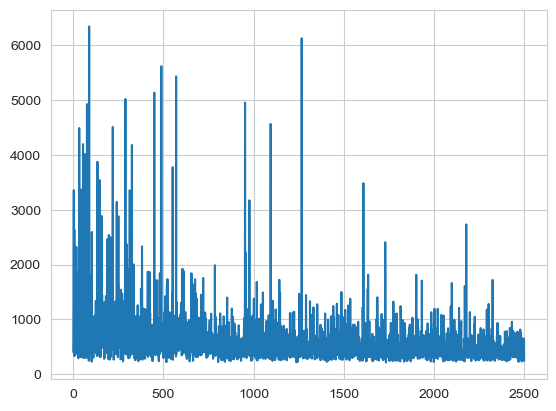

In [238]:
plt.plot(burnin_losses_DEBUG)

In [139]:
# DEBUG
# {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}

In [239]:
def plot_parameter_optimization(results):
    np_results = results.numpy().T
    _, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(np.abs(np_results[0]), label="Forage", color="b")
    ax.plot(np.abs(np_results[1]), label="Intermediate", color="g")
    ax.plot(np.abs(np_results[2]), label="Apex", color="r")
    
    for r in msr_rates:
        ax.axhline(r, color="k", linestyle="--")
    
    ax.legend()
    return ax

<Axes: >

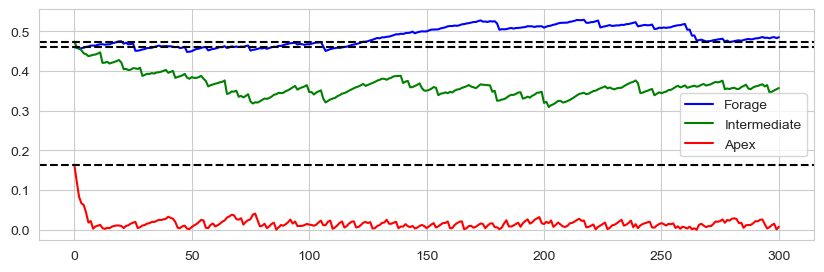

In [240]:
plot_parameter_optimization(pamc_result)

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

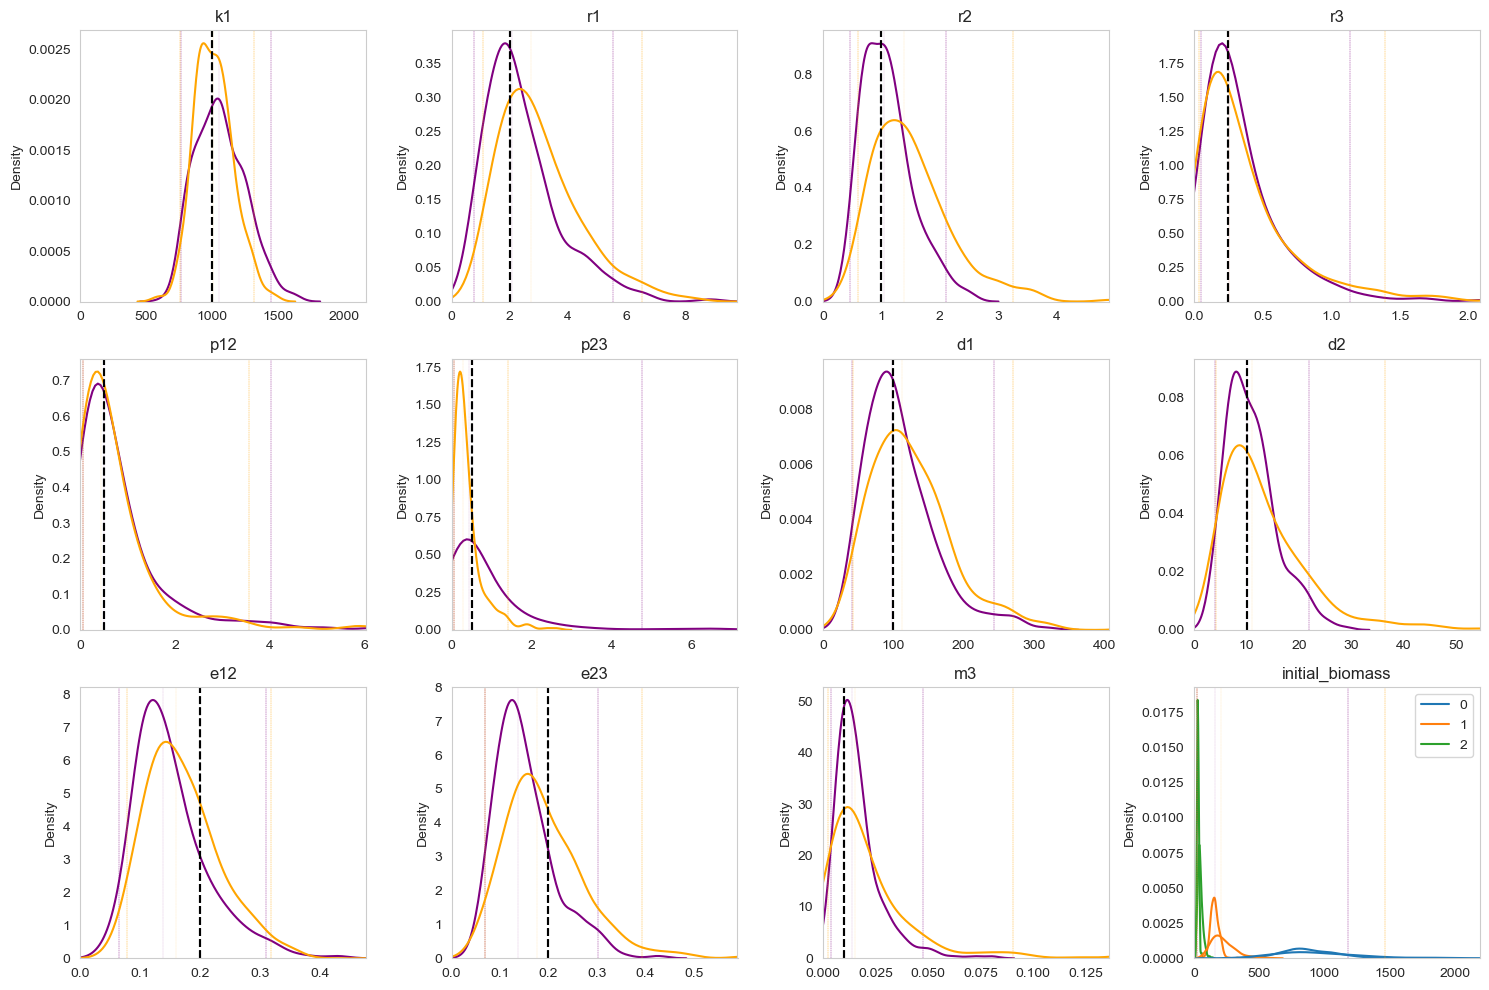

In [142]:
with pyro.plate("samples", len(pamc_result)): 
    plot_marginals(joint_prior(), pamc_guide(), truevals=TRUEVALS)

In [143]:
# Generate data to plot the posterior predictive.
pamc_obs_expl_biomass_at_times_list, pamc_obs_pause_biomass_at_times_list = [], []
pamc_mean_expl_biomass_at_times_list, pamc_mean_pause_biomass_at_times_list = [], []
# Use replay to play the guide trace through the fully observed temporal model.
for i in range(n):
    trace = pyro.poutine.trace(pamc_guide).get_trace()
    
    res = pyro.poutine.replay(full_observed_fishery_model, trace)()
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times, _, _ = res
    
    pamc_obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times.detach())
    pamc_obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times.detach())
    pamc_mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times.detach())
    pamc_mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times.detach())
    
pamc_obs_expl_biomass_at_times = torch.stack(pamc_obs_expl_biomass_at_times_list)
pamc_obs_pause_biomass_at_times = torch.stack(pamc_obs_pause_biomass_at_times_list)
pamc_mean_expl_biomass_at_times = torch.stack(pamc_mean_expl_biomass_at_times_list)
pamc_mean_pause_biomass_at_times = torch.stack(pamc_mean_pause_biomass_at_times_list)

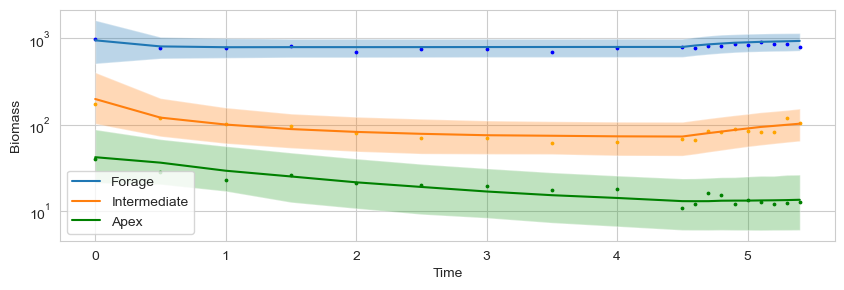

In [144]:
# Plot the posterior predictive.
pamc_obs_expl_and_pause_biomass_at_times = torch.cat([pamc_obs_expl_biomass_at_times, pamc_obs_pause_biomass_at_times], dim=-1).detach()
pamc_mean_expl_and_pause_biomass_at_times = torch.cat([pamc_mean_expl_biomass_at_times, pamc_mean_pause_biomass_at_times], dim=-1).detach()

pamc_obs_expl_and_pause_biomass_at_times_q = torch.quantile(pamc_obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
pamc_mean_expl_and_pause_biomass_at_times_q = torch.quantile(pamc_mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)

_, ax = plot_biomass_over_time_with_ci(expl_and_pause_times, pamc_mean_expl_and_pause_biomass_at_times_q, show=False)

# And plot the original data with a scatter. The stuff that's being conditioned on in the model.
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)

In [145]:
# # DEBUG
# # AutoDelta Guide
# true_delta_guide = pyro.infer.autoguide.AutoDelta(
#     pamc_model,
#     init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()})
# )
# 
# pamc_msr_result = torch.stack([params for params in pamc(
#     model=pamc_model,
#     # guide=pamc_guide,
#     guide=true_delta_guide,  # DEBUG instead of above.
#     svi_lr=1e-3,
#     fpo_lr=1e-3,
#     fpo_clip=30.0,
#     burnin_iters=0,
#     opt_iters=500,
#     obj_scaling=dict(
#         revenue=0.0,
#         disturbance=1.0,
#         extinction=0.0,
#     ),
#     # debias=False
# )])

In [146]:
# # DEBUG
# ax = plot_parameter_optimization(pamc_msr_result)
# # print(msr_rates)

#### Addressing Large Gradients

The relaxed extinction penalty has a very large, very localized gradient in the tail of the distribution. This means that rare, but very large jumps are destabilizing the optimization process. Based on our gradient magnitude histograms, it's unlikely that this stems from the revenue objective, and seems to only affect the intermediate and apex predators.

To address the instability, we'll selectively apply TABDM to target the partial derivatives of the extinction penalty for the intermediate and apex predators only.

In [147]:
from typing import Callable

def build_pseudo_density(
        factor_name: str,
        model,
        target_fn: Callable[[OrderedDict], torch.Tensor],
        positive_component: bool = True,
        log_fac_eps: float = 1e-25,
        heuristic_exponentiation: float = 1.0  # TODO explain
):
    
    print("Building PS", f"Name: {factor_name}", f"Positive: {positive_component}", f"Log Fac Eps: {log_fac_eps}")
    def pseudo_density():
        # Execute the (potentially conditioned) model.
        model_ret = model()
        # Pull parameters and initial biomass samples from the return tuple.
        s = model_ret[-2]
        s["initial_biomass"] = model_ret[-1]  # TODO HACK 2801gdl clean this up
        
        fn_result = target_fn(s)
        
        if positive_component:
            fn_result = torch.relu(fn_result)
        else:
            fn_result = torch.relu(-fn_result)
            
        # DEBUG spie8vne add a log factor to k1 that is just a gaussian centered at 500.
        # pyro.factor("debugk1", -.5*((s["k1"] - 500.)/10.)**2.)
        
        # Finally, add a log factor corresponding to the target function.
        pyro.factor(factor_name, heuristic_exponentiation * torch.log(fn_result + log_fac_eps))
    
    return pseudo_density

In [249]:
from typing import Callable, Tuple
from itertools import product
from copy import deepcopy

GuideType = Callable[[], OrderedDict[str, torch.Tensor]]

# TODO so pure PAMC is a special case of this, meaning we can just get rid of the PAMC function if we pass the tabi targeting structure
#  as an argument.
def f_tabdm(
        conditioned_model,
        # Guide that approximates the posterior induced by the conditioned model above.
        posterior_guide: GuideType,
        # Callable that takes a model and constructs a guide for it.
        build_targeted_guide: Callable[[Callable], GuideType],
        svi_lr: float,
        fpo_lr: float,
        fpo_clip: float,
        burnin_iters: int,
        opt_iters: int,
        obj_scaling=None,
        all_targeted_guides=None,  # optional place that targeted guides will be stored.
        heuristic_exponentiation: float = 1.0
    ):
    
    full_obj_scaling = OBJECTIVE_SCALING_DICT if obj_scaling is None else obj_scaling
    
    # Policy parameters we're trying to optimize. We start this at zero because the gradients of the extinction event
    #  are only defined on the left hand side wrt the fishing policy parameters. This is because, if the fishing rate
    #  is too high, extinction is often guaranteed, and infinitesmal changes in the fishing rate won't change that.
    tabi_fpp = (torch.zeros_like(msr_rates.detach().clone()) + 0.01).requires_grad_()  # DEBUG + 0.01
    
    # The full multiobjective.
    multiobjective = build_full_rescaled_multiobjective_f(full_obj_scaling, return_vec=True)
    
    # TODO couch this maping stuff in numpy object arrays. Then use their mapping functionality.
    
    # Specify which elements and sides (-/+) of the jacobian we want to target — i.e. those which are tail heavy.
    # The extinction gradients are essentially always negative, and are particulary heavily tailed for the intermediate and apex predators.
    # Side is (negative, positive).
    # This also demonstrates the poor scaling of gradient targeting in cases where you want to target everything.
    jac_targeting = [
        # forage          intermediate    apex
        [[False, False], [False, False], [False, False]],  # revenue
        [[False, False], [False, False], [False, False]],  # disturbance
        [[False, False], [True,  False], [True,  False]]   # extinction
    ]
    
    nouts = len(jac_targeting)
    nparams = len(jac_targeting[0])
    nsides = 2
    targeting_indices = lambda: product(range(nouts), range(nparams), range(nsides))
    
    # We'll use this structure below, so just create an empty placeholder here.
    empty_targeting_structure = deepcopy(jac_targeting)
    for out_idx, param_idx, side_idx in targeting_indices():
        empty_targeting_structure[out_idx][param_idx][side_idx] = None
    
    # Helper utility for applying functions to elements in the "sided" jacobian structure.
    # TODO add parallelization option — would be nice to demo this, as nearly all of the poor scaling that
    #  TABDM induces is parallelizeable.
    def map_onto_jac_structures(fn: Callable, *structures, **kwargs):
        mapped_structure = deepcopy(empty_targeting_structure)
        
        for o_, p_, s_ in targeting_indices():
            eles = tuple(structure[o_][p_][s_] for structure in structures)
            
            # If any evaluate to false, skip.
            if any((not ele) for ele in eles):
                if any(ele for ele in eles):
                    raise ValueError("Some elements eval to false, while others do not.")
                continue
            
            mapped_structure[o_][p_][s_] = fn((o_, p_, s_), *eles, **kwargs)
        
        return mapped_structure
    
    # <Pseudodensity Construction>
    # We've found that differentiating through the analytic gradient a second time with respect to variational parameters is unstable.
    # To address this, we demonstrate a useful feature of TABDM — that we can target an approximation of the quantity of interest curve
    #  and then use the non-approximate version for actual estimation.
    
    def build_fd_pseuden(idx, process_ele: bool):
        assert process_ele
        out_idx, param_idx, side_idx = idx
        
        lbl = f"ele_{out_idx},{param_idx}_{'p' if side_idx else 'n'}_pseudo_density"
        print("Targeting", lbl)
        
        return build_pseudo_density(
            lbl + "_factor",
            conditioned_model,
            build_fd_jac_ij(
                obj_fn=multiobjective,
                output_idx=out_idx,
                input_idx=param_idx,
                fishing_mortality_rates_outer=tabi_fpp,
            ),
            positive_component=bool(side_idx),
            # Add an exponentiation to overcome the fact that we're approximating with finite differences. Otherwise
            # The posterior overwhelms the pseud density curve and targeting is poor.
            heuristic_exponentiation=heuristic_exponentiation
        )
    
    def build_ana_pseuden(idx, process_ele: bool):
        assert process_ele
        out_idx, param_idx, side_idx = idx
        
        lbl = f"ele_{out_idx},{param_idx}_{'p' if side_idx else 'n'}_pseudo_density"
        print("Targeting", lbl)
        
        multiobjective_jac = build_jac(multiobjective, create_graph=False)
        
        return build_pseudo_density(
            lbl + "_factor",
            conditioned_model,
            # We aren't going to diff through this again, so don't bother creating the graph.
            lambda s: multiobjective_jac(s, tabi_fpp)[out_idx, param_idx],
            positive_component=bool(side_idx),
            # Note that we do not use the exponentiation here, as this is the actual quantity of interest.
        )
        
    # Initialize the structure for filling.
    fd_pseudens = map_onto_jac_structures(build_fd_pseuden, jac_targeting)
    ana_pseudens = map_onto_jac_structures(build_ana_pseuden, jac_targeting)
    
    # </Pseudodensity Construction>
    
    # Create guides for targeting the finite difference pseudo densities. 
    fd_targeted_guides = map_onto_jac_structures(lambda idx, pseuden: build_targeted_guide(pseuden), fd_pseudens)
    # Expose to user by appending to the provided collection.
    if all_targeted_guides is not None:
        map_onto_jac_structures(lambda idx, guide: all_targeted_guides.append(guide), fd_targeted_guides)
    
    targeted_guide_fitters = map_onto_jac_structures(
        lambda idx, guide, pseuden: build_fit_variational_approximation(guide=guide, pseudo_density=pseuden, lr=svi_lr),
        fd_targeted_guides,
        fd_pseudens
    )
    
    # Fit the targeted guides for the number of specified "burnin" iterations.
    def fit(idx, fitter, iters=1, msg=False):
        o_, p_, s_ = idx
        for i in range(iters):
            if msg:
                print(f"Fitting Element {o_},{p_},{'p' if s_ else 'n'}: {i:06d}", end="\r")
            fitter()
        print()
    map_onto_jac_structures(fit, targeted_guide_fitters, iters=burnin_iters, msg=True)
    
    # Construct the importance sampling estimators of the TABI gradients.
    log_normalizing_constant_estimators = map_onto_jac_structures(
        lambda idx, ana_pseuden, fd_targeted_guide: build_estimate_log_normalizing_constant(
            pseudo_density=ana_pseuden,
            proposal=fd_targeted_guide,
            no_grad=True
        ),
        ana_pseudens,
        fd_targeted_guides
    )
    
    # Construct the posterior normalizing constant estimator.
    posterior_log_normalizing_constant_estimator = build_estimate_log_normalizing_constant(
        conditioned_model,
        posterior_guide,
        no_grad=True
    )
    
    # And define the TABI estimator.
    unsided_targeting_indices = lambda: product(range(nouts), range(nparams))
    def compute_tabi_jacobian_estimate(log_norm_const_estors, post_log_norm_const_estor) -> Tuple[torch.Tensor, torch.Tensor]:
        estimate = torch.zeros(nouts, nparams)
        tabid_mask = torch.zeros(nouts, nparams)
        for o_, p_ in unsided_targeting_indices():
            log_neg_estor, log_pos_estor = log_norm_const_estors[o_][p_]
            noneg = log_neg_estor is None
            nopos = log_pos_estor is None
            
            if noneg and nopos:
                continue  # already zero.
            
            for _ in range(5):
                with solver_error_suppression():
                    log_neg = log_neg_estor() if not noneg else torch.tensor(-torch.inf)
                    log_pos = log_pos_estor() if not nopos else torch.tensor(-torch.inf)
                    log_den = post_log_norm_const_estor()
                    
                    print()
                    
                    print("Log Neg", log_neg)
                    print("Log Pos", log_pos)
                    print("Log Den", log_den)
                    
                    log_rescaled_pos = log_pos - log_den
                    log_rescaled_neg = log_neg - log_den
                    
                    print("Log Rescaled Pos (log_pos - log_den)", log_rescaled_pos)
                    print("Log Rescaled Neg (log_neg - log_den)", log_rescaled_neg)
                    
                    rescaled_pos = torch.exp(log_rescaled_pos)
                    rescaled_neg = torch.exp(log_rescaled_neg)
                    
                    print("Rescaled Pos", rescaled_pos)
                    print("Rescaled Neg", rescaled_neg)
                
                    estimate[o_, p_] = rescaled_pos - rescaled_neg
                    tabid_mask[o_, p_] = torch.tensor(1.)
            
        return estimate, tabid_mask
    
    # For non-targeted elements, we're just going to use a straightforward PAMC approach.
    multiobjective_jac = build_jac(multiobjective, create_graph=False)  # DEBUG want this to be create_graph=False 
    
    # <Optimization Loop>
    step_policy_param = build_step_policy_param(tabi_fpp, fpo_lr, fpo_clip)
    
    
    yield tabi_fpp.detach().clone()
    
    for oi in range(burnin_iters, burnin_iters + opt_iters):
        
        print(f"Optimization Iteration: {oi:05d}", end="\r")
        
        for _ in range(5):
            with solver_error_suppression():
            
                # Start with just the standard pamc estimate.
                guide_trace = pyro.poutine.trace(posterior_guide).get_trace()
                stochastics = kft(guide_trace)
                
                # PAMC
                jac_estimate_pamc = multiobjective_jac(stochastics, tabi_fpp)
                # print("PAMC", jac_estimate_pamc)
                if not torch.isfinite(jac_estimate_pamc).all():
                    raise RuntimeError("PAMC gradient estimate is non-finite.")
                
                # Update the targeted guides.
                map_onto_jac_structures(fit, targeted_guide_fitters, iters=1)
                
                # TABI
                jac_estimate_tabi, tabid_mask = compute_tabi_jacobian_estimate(
                    log_norm_const_estors=log_normalizing_constant_estimators,
                    post_log_norm_const_estor=posterior_log_normalizing_constant_estimator
                )
                # print("TABI", jac_estimate_tabi)
                # print("TABI Mask", tabid_mask)
                if not torch.isfinite(jac_estimate_tabi).all():
                    raise RuntimeError("TABI gradient estimate is non-finite.")
                
                # Combine the estimates.
                jac_estimate = jac_estimate_pamc * (1. - tabid_mask) + jac_estimate_tabi * tabid_mask
                
                # Sum the estimates.
                grad_estimate = jac_estimate.sum(dim=0)
                step_policy_param(grad_estimate)
    
        yield tabi_fpp.detach().clone()
    
    print()
    
    # </Optimization Loop>


In [250]:
targeted_guides = []
f_tabdm_result = torch.stack([params for params in f_tabdm(
    conditioned_model=conditioned_model_,
    posterior_guide=pamc_guide,  # use the guide already fit to the posterior.
    build_targeted_guide=lambda model: GMMGuide(
        init_loc=prior_log_locs.detach().clone(),
        init_scale_vec=prior_log_scales.detach().clone(),
        ncomponents=5,
        model=model
    ),
    svi_lr=3e-3,
    fpo_lr=1e-3,
    fpo_clip=20.0,
    # burnin_iters=2500,
    burnin_iters=50,
    opt_iters=300,
    all_targeted_guides=targeted_guides,
    heuristic_exponentiation=500
)])

Targeting ele_2,1_n_pseudo_density
Building PS Name: ele_2,1_n_pseudo_density_factor Positive: False Log Fac Eps: 1e-25
Targeting ele_2,2_n_pseudo_density
Building PS Name: ele_2,2_n_pseudo_density_factor Positive: False Log Fac Eps: 1e-25
Targeting ele_2,1_n_pseudo_density
Building PS Name: ele_2,1_n_pseudo_density_factor Positive: False Log Fac Eps: 1e-25
Targeting ele_2,2_n_pseudo_density
Building PS Name: ele_2,2_n_pseudo_density_factor Positive: False Log Fac Eps: 1e-25


KeyError: -2

<Axes: >

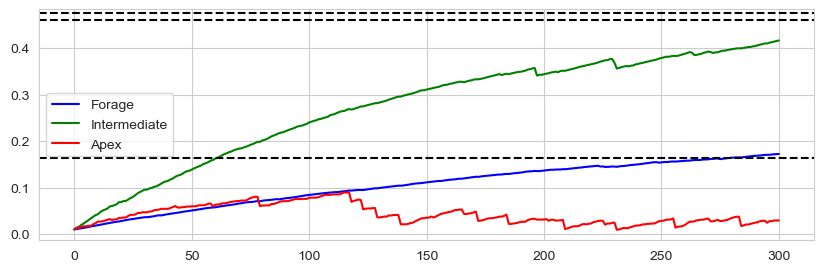

In [245]:
plot_parameter_optimization(f_tabdm_result)

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

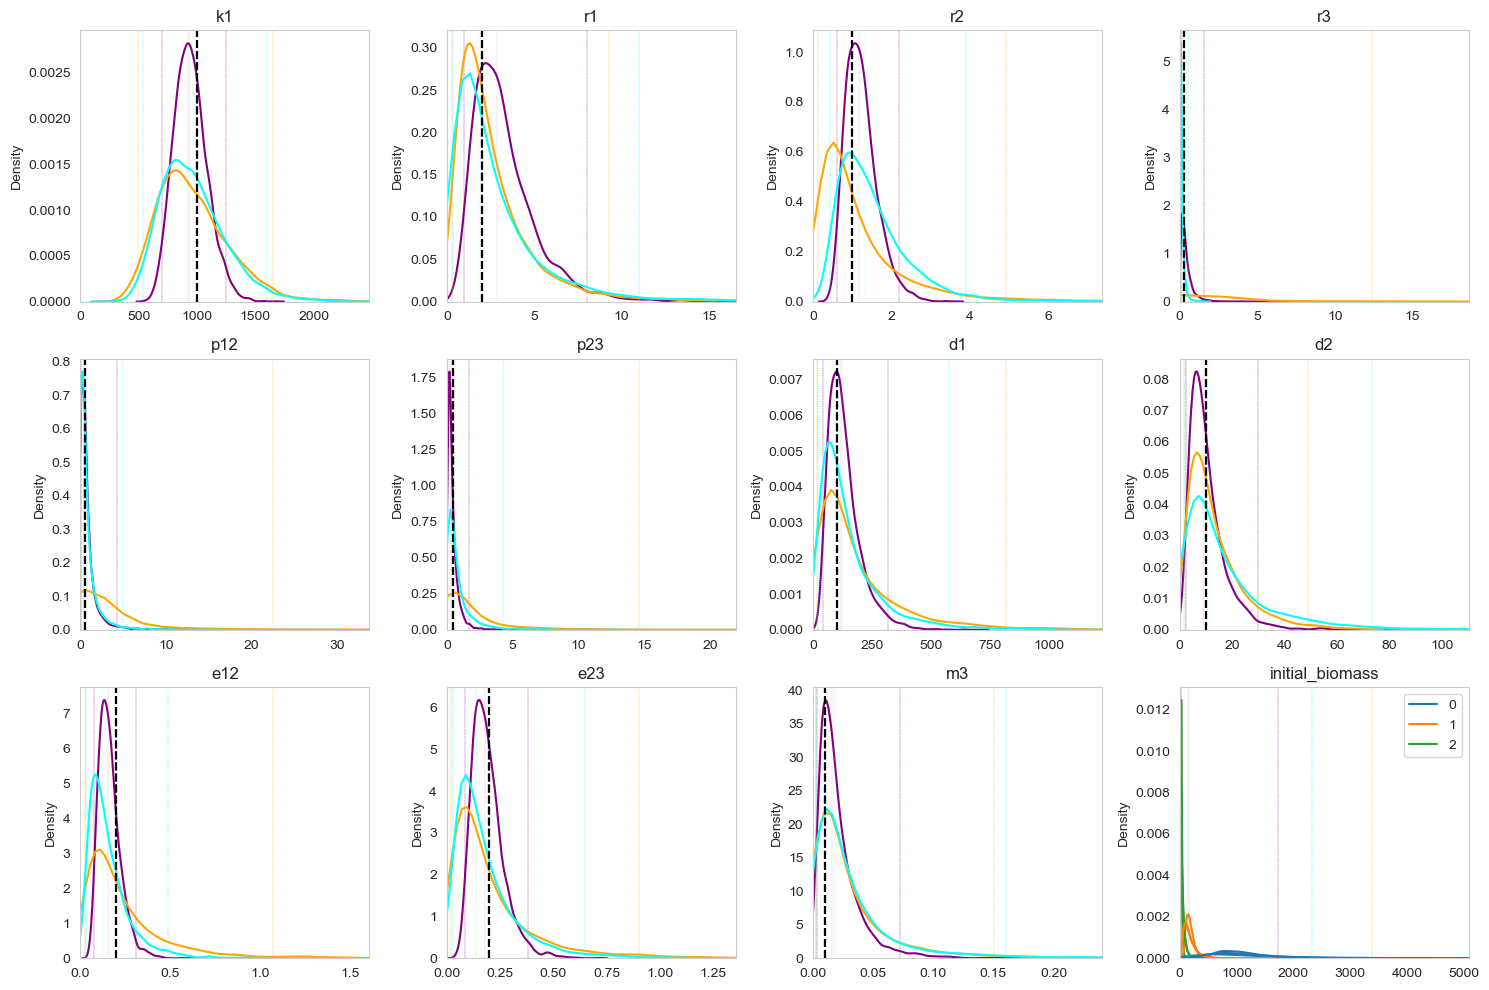

In [246]:
with pyro.plate("samples", 5000):
    plot_marginals(
        pamc_guide(),
        targeted_guides[0](),
        targeted_guides[1](),
        truevals=TRUEVALS
    )

In [ ]:
def index_into_samples(samples, idx):
    return OrderedDict({k: v[idx] for k, v in samples.items()})

In [ ]:
def pairwise_scatter(guide, color_by_extinction_grad=False, use_fd=True, n=5000, msr_scaling=1., manual_noise_non_whitelist=0.01, use_grad_factor=False):
    
    with pyro.plate("samples", n):
        samples = guide()
    
    if color_by_extinction_grad:
        # Build the extinction grad.
        if use_fd:
            multiobjective = build_full_rescaled_multiobjective_f(OBJECTIVE_SCALING_DICT, return_vec=True)
            multiobjective_grad = build_fd_jac_ij(
                obj_fn=multiobjective,
                output_idx=2, # extinction
                input_idx=2, # apex fishing rate
                fishing_mortality_rates_outer=msr_rates * msr_scaling
            )
        else:
            multiobjective = build_full_rescaled_multiobjective_f(OBJECTIVE_SCALING_DICT, return_vec=True)
            multiobjective_grad_all = build_jac(multiobjective)
            def multiobjective_grad(s):
                mga = multiobjective_grad_all(s, msr_rates * msr_scaling)
                return mga[2, 2]
                
            
        # Pull each vector out and run it through to compute the extinction for each, use color.
        extinction_grads = []
        for i in range(n):
            s = index_into_samples(samples, i)
            extinction_grads.append(multiobjective_grad(s).item())
            
            # Report progress with /r
            print(f"Computing Apex Extinction Grad: {i:05d}", end="\r")
        print()
    
    samples.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
    
    fig, axs = plt.subplots(len(samples), len(samples), figsize=(30, 30))
    
    num_keys = len(samples)
    
    # Add colorbar if looking at extinction grads. Use the actual extinction grads list directly to 
    #  set the bounds of the colorbar. Then use that cmap to color the points.
    if color_by_extinction_grad:
        if use_grad_factor:
            extinction_grads = torch.log(torch.relu(-torch.tensor(extinction_grads)) + 1e-25)  # Show the neg factor not just the grads.
        else:
            extinction_grads = torch.tensor(extinction_grads)
        norm = plt.Normalize(extinction_grads.min(), extinction_grads.max())
        cmap = plt.get_cmap("viridis")
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=axs, orientation="horizontal")
        
    
    for i, j in product(range(num_keys), range(num_keys)):
        ik = list(samples.keys())[i]
        jk = list(samples.keys())[j]
        
        # Set x and y labels only for the bottom row and leftmost column.
        if i == num_keys - 1:
            axs[i, j].set_xlabel(jk)
        if j == 0:
            axs[i, j].set_ylabel(ik)
            
        if i == j:
            continue
        
        nsamples = samples[ik].shape[0]
        ik_noise = torch.normal(0.0, manual_noise_non_whitelist, (nsamples,)) if ik not in prior_whitelist else 0.0
        jk_noise = torch.normal(0.0, manual_noise_non_whitelist, (nsamples,)) if jk not in prior_whitelist else 0.0 
        
        
        axs[i, j].scatter(
            samples[ik].detach() + ik_noise, 
            samples[jk].detach() + jk_noise, 
            s=1., 
            c=extinction_grads if color_by_extinction_grad else "b",
            cmap=cmap if color_by_extinction_grad else None
        )

    return fig, axs

In [ ]:
pairwise_scatter(targeted_guides[0])
pairwise_scatter(targeted_guides[1])
pairwise_scatter(pamc_guide)

In [ ]:
# DEBUG
# Hist plot the extinction objective at msr_rates.
def plot_extinction_hist(fpp, guide, output_idx, input_idx):
    
    exts = []
    fd_grads = []
    ana_grads = []
    
    fpp = fpp.detach().clone().requires_grad_()
    
    multobjective_fn = build_full_rescaled_multiobjective_f(OBJECTIVE_SCALING_DICT, return_vec=True)
    
    fd_jac_fn = build_fd_jac_ij(
        obj_fn=multobjective_fn,
        output_idx=output_idx,
        input_idx=input_idx,
        fishing_mortality_rates_outer=fpp
    )
    
    ana_jac_fn = build_jac(multobjective_fn)
    
    for i in range(250):
        s = guide()
        
        penalty = multobjective_fn(s, fpp)[output_idx]
        fd_grad = fd_jac_fn(s)
        try:
            ana_grad = ana_jac_fn(s, fpp)[output_idx, input_idx]
            ana_grads.append(ana_grad.item())
        except JuliaError as e:
            print("Failed ana jac with message", str(e)[:30])
        
        exts.append(penalty.item())
        fd_grads.append(fd_grad.item())
        
        print(f"Sample: {i:05d}", end="\r")
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].hist(exts, bins=50)
    axs[1].hist(fd_grads, bins=50)
    axs[2].hist(ana_grads, bins=50)
    

In [ ]:
# DEBUG
plot_extinction_hist(msr_rates, pamc_guide, output_idx=2, input_idx=2)

In [ ]:
plot_extinction_hist(msr_rates, targeted_guides[0], output_idx=2, input_idx=1)
plot_extinction_hist(msr_rates, targeted_guides[0], output_idx=2, input_idx=2)

In [ ]:
plot_extinction_hist(msr_rates, targeted_guides[1], output_idx=2, input_idx=2)
plot_extinction_hist(msr_rates, targeted_guides[1], output_idx=2, input_idx=1)

In [ ]:
def conditioned_model_with_simple_output():
    s, initial_biomass = conditioned_model_()[-2:]
    s["initial_biomass"] = initial_biomass  # HACK 2801gdl clean this up
    return s

In [ ]:
# DEBUG
# 1. create a pseudens that is just the full prior but with a log factor added to it for k1.
# 2. create a guide that uses our gmm guide thing.
# 3. build variational fitter
# 4. run the fitter.
# 5. plot the stuff.

msr_scaling_ptr = [None]  # DEBUG 291jdksll92

def test_pseudens():
    msr_scaling = msr_scaling_ptr[0]
    
    # s = joint_prior()
    s = conditioned_model_with_simple_output()
    
    # # <DEBUG HACK to condition SVI on cases where the unfished regime is non-extinct.>
    # # Check if unfished state has extinction.
    # unfished_biomass = fishery_steady_state(
    #     s,
    #     s["initial_biomass"],
    #     msr_rates * msr_scaling
    # )
    # 
    # 
    # if torch.any(unfished_biomass < 1e-5):
    #     return
    # # </DEBUG HACK to condition SVI on cases where the unfished regime is non-extinct.>
    
    # pyro.factor("debugk1", -.5*((s["k1"] - 500.)/10.)**2.)
    # pyro.factor("debugr1", -.5*((s["r1"] - 5.)/.003)**2.)
    
    # # <Extinction Direct>
    # initial_biomass = s.pop("initial_biomass")  # HACK 2801gdl clean this up
    # 
    # steady_biomass = fishery_steady_state(
    #     s,
    #     initial_biomass,
    #     # Trying a lower fishing rate, as that should push the extinction events to be much rarer, meaning that the
    #     #  the optimal proposal will be more rare.
    #     msr_rates * msr_scaling
    # )
    # 
    # penalty = extinction_event(
    #     fished_biomass=steady_biomass,
    #     unfished_biomass=initial_biomass,
    # )
    # 
    # pyro.factor("extinction_penalty", torch.log(penalty * OBJECTIVE_SCALING_DICT["extinction"]))
    # 
    # # # <Extinction Slopey Part>
    # # # A funky hack, where we slap a factor that's just a normal on the extinction rate itself, but push that through a normal centered in the middle
    # # #  of the threshold relaxation.
    # # 
    # # # penalty ranges from 0 to 1, we want stuff in the middle on the slope.
    # # # print(penalty)
    # # middlin_penalty = -.5 * ((penalty - 0.5) / .25) ** 2.
    # # pyro.factor("extinction_middlin_penalty", middlin_penalty)
    # # # </Extinction Slopey Part>
    # 
    # # </Extinction Direct>
    
    # <Grad 2 2>
    multobjective_fn = build_full_rescaled_multiobjective_f(OBJECTIVE_SCALING_DICT, return_vec=True)
    fd_jac_22_fn = build_fd_jac_ij(
        obj_fn=multobjective_fn,
        output_idx=2,
        input_idx=2,
        fishing_mortality_rates_outer=msr_rates * msr_scaling
    )

    penalty_grad_22 = fd_jac_22_fn(s)
    # print("Adding factor", torch.log(torch.relu(-penalty_grad_22) + 1e-50))

    # Negative component only.
    pyro.factor("extinction_penalty_grad", 500.*torch.log(torch.relu(-penalty_grad_22) + 1e-25))
    # </Grad 2 2>

In [ ]:
# TODO WIP try a guide that doesn't do the exp transform. So I think will need to log itself so the easy/autoguide log transform is cancelled out.

In [ ]:
msr_scaling_ptr[0] = torch.tensor(0.0).double()  # DEBUG 291jdksll92

In [ ]:
test_guide = GMMGuide(
    init_loc=prior_log_locs.detach().clone(),
    init_scale_vec=prior_log_scales.detach().clone(),
    ncomponents=5,
    model=test_pseudens
)

test_fitter = build_fit_variational_approximation(
    pseudo_density=test_pseudens,
    guide=test_guide,
    lr=1e-3
)

In [ ]:
N = 8000
losses = []
for i in range(N):
    print(f"Iteration: {i:05d}", end="\r")
    loss = test_fitter()
    if loss is not None:
        losses.append(loss)
    else:
        print("Failed to compute loss even after retries.")
    
    # Anneal up to the msr_scaling. DEBUG 291jdksll92
    msr_scaling_ptr[0] = torch.tensor((i + 1) / N).double()

In [ ]:
# Plot losses.
plt.plot(losses, linewidth=0.1)

In [ ]:
# DEBUG
plt.figure()
with pyro.plate("samples", 5000):
    plot_marginals(joint_prior(), pamc_guide(), test_guide(), truevals=TRUEVALS)

In [ ]:
# DEBUG
# pairwise_scatter(test_guide)

In [ ]:
# DEBUG
# plot_extinction_hist(msr_rates * msr_scaling_ptr[0], test_guide, output_idx=2, input_idx=1)
# plot_extinction_hist(msr_rates * msr_scaling_ptr[0], pamc_guide, output_idx=2, input_idx=1)

In [ ]:
# DEBUG
plot_extinction_hist(msr_rates * msr_scaling_ptr[0], test_guide, output_idx=2, input_idx=2)

In [ ]:
# DEBUG
plot_extinction_hist(msr_rates * msr_scaling_ptr[0], joint_prior, output_idx=2, input_idx=2)

In [ ]:
# DEBUG
plot_extinction_hist(msr_rates * msr_scaling_ptr[0], pamc_guide, output_idx=2, input_idx=2)

In [ ]:
pairwise_scatter(test_guide, color_by_extinction_grad=True, use_fd=False, n=500, msr_scaling=msr_scaling_ptr[0], use_grad_factor=False)

In [ ]:
pairwise_scatter(test_guide, color_by_extinction_grad=True, use_fd=True, n=500, msr_scaling=msr_scaling_ptr[0], use_grad_factor=False)

#### 

TODO look into optimization stuff in re remaking and replacing rather than instantiating new problems.
https://docs.sciml.ai/ModelingToolkit/stable/examples/remake/#Optimizing-through-an-ODE-solve-and-re-creating-MTK-Problems 

### Analysis of One-Sided Approach
See lyx doc called "tabdm_woes" on gray mac. TODO port that over to space mac.

In [ ]:
# We want to draw a slew of samples from the prior, and then generate two pairwise scatters where extinction does/does not occur in the unfished regime. This will tell us roughly what the prior should look like if we were to condition on extinction not occurring in the unfished regime.
N = 200

with pyro.plate("samples", N):
    samples = joint_prior()
    
# rates_for_one_side_approach_analysis = torch.zeros_like(msr_rates)  # unfished regime.
rates_for_one_side_approach_analysis = torch.tensor(0.8).double() * APPROX_GROWTH_RATES  # DEBUG
# rates_for_one_side_approach_analysis = msr_rates * 0.5

# Extinction occurred in unfished mask.
extinction_occurred_in_unfished = []
extinction_gradient_zero = []
for i in range(N):
    s = index_into_samples(samples, i)
    initial_biomass = s["initial_biomass"]
    steady_biomass = fishery_steady_state(
        s,
        initial_biomass,
        rates_for_one_side_approach_analysis
    )
    
    extinction_occurred_in_unfished.append(
        torch.any(torch.isclose(steady_biomass, torch.tensor(0.).double()))
    )
    
    multobjective_fn = build_full_rescaled_multiobjective_f(OBJECTIVE_SCALING_DICT, return_vec=True)
    fd_jac_22_fn = build_fd_jac_ij(
        obj_fn=multobjective_fn,
        output_idx=2,
        input_idx=2,
        fishing_mortality_rates_outer=rates_for_one_side_approach_analysis
    )
    extinction_gradient_zero.append(
        torch.isclose(fd_jac_22_fn(s), torch.tensor(0.).double())
    )


In [ ]:
extinction_occurred_in_unfished = torch.tensor(extinction_occurred_in_unfished)
extinction_gradient_zero = torch.tensor(extinction_gradient_zero)

In [ ]:
print("Rate of Extinction in Unfished Regime:", torch.mean(extinction_occurred_in_unfished.double()))
print("Rate of Zero Gradient in Extinction Gradient in Unfished Regime:", torch.mean(extinction_gradient_zero.double()))

In [ ]:
# TODO combine with original pairwise scatter fn.
def pairwise_scatter_samples(samples, mask):
    samples = deepcopy(samples)
    samples.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
    
    fig, axs = plt.subplots(len(samples), len(samples), figsize=(30, 30))
    
    num_keys = len(samples)
    
    cmap = plt.get_cmap("brg")
    
    for i, j in product(range(num_keys), range(num_keys)):
        ik = list(samples.keys())[i]
        jk = list(samples.keys())[j]
        
        # Set x and y labels only for the bottom row and leftmost column.
        if i == num_keys - 1:
            axs[i, j].set_xlabel(jk)
        if j == 0:
            axs[i, j].set_ylabel(ik)
            
        if i == j:
            continue
        
        axs[i, j].scatter(
            samples[ik].detach(), 
            samples[jk].detach(), 
            s=5., 
            c=mask,
            cmap=cmap,
            alpha=0.4
        )

    return fig, axs

pairwise_scatter_samples(samples, extinction_occurred_in_unfished)
pairwise_scatter_samples(samples, extinction_gradient_zero)